# Notebook configuration

In [1]:
run_number    = 4626
save_plots    = False
plots_format  = "pdf"
outputfolder  = "plots/{}/".format(run_number)
corr_filename = "run{}_corrections.h5".format(run_number)
#copy_corr_to  = "/Users/Gonzalo/github/NEXTdata/XYmaps/"
inputfilename = "/home/brais/Documents/Next/Kr/data/{0}/dst_{0}.root.h5".format(run_number)

Zrange        =     0, 600
XYrange       =  -198, 198
Rrange        =     0, max(XYrange)
Prange        =  -3.2, 3.2  
Erange_raw    =     0, 15e3
Erange_zcorr  =   5e3, 15e3
Erange_xycorr =   9e3, 14e3
Erange_fit    = 11500, 13500
Qrange        =     0, 10e2
QErange       =     0, Qrange[1]/Erange_xycorr[1]
Frange        =   0.8, 1.5
Urange        =  1e-3, 1.2e-2

S1Erange      =     0, 40
S1Wrange      =     0, 400
S1Hrange      =     0, 10
S2Wrange      =     0, 50
S2Hrange      =     0, 10e3
NSirange      =     0, 30

Zrange_DV     =   545, 555
Zrange_LT     =    50, 520
Zrange_XY     =     0, 520
nX, nY, nR    =    50,  50, 50
x0, y0, r0    =    40, -40, 15 # for lifetime scan

extra_pitches = [( 25,  25),
                 ( 50,  50),
                 ( 75,  75),
                 (100, 100)]

split_sample  = True

In [2]:
Emin_fit      = Erange_fit[0]
Emax_fit      = Erange_fit[1]
Emean_fit     = 0.5*sum(Erange_fit)

# Kr analysis

In [3]:
import os
import shutil
import functools
import time
print("Running on ", time.asctime())

import numpy             as np
import tables            as tb
import matplotlib.pyplot as plt
from   matplotlib.colors import LogNorm

import invisible_cities.core.core_functions as coref
import invisible_cities.core.fit_functions  as fitf
import invisible_cities.reco.dst_functions  as dstf
import invisible_cities.io  .kdst_io        as kdstio
import invisible_cities.reco.corrections    as corrf

from invisible_cities.icaro.hst_functions import hist
from invisible_cities.icaro.hst_functions import hist2d
from invisible_cities.icaro.hst_functions import pdf
from invisible_cities.icaro.hst_functions import labels
from invisible_cities.icaro.hst_functions import display_matrix
from invisible_cities.icaro.hst_functions import covariance
from invisible_cities.icaro.hst_functions import resolution
from invisible_cities.icaro.hst_functions import poisson_sigma
from invisible_cities.icaro.hst_functions import gausstext
from invisible_cities.icaro.hst_functions import shift_to_bin_centers
from invisible_cities.icaro.hst_functions import plot_writer
from invisible_cities.icaro.hst_functions import measurement_string


xy_map = dstf.load_xy_corrections("../Na_June_Axial/merged_corrections.h5")

pi   = np.pi
save = plot_writer(outputfolder, plots_format) if save_plots else lambda *x: None

Running on  Thu Sep  7 12:32:30 2017


#### General plotting options

In [4]:
%matplotlib inline

np.warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"]          = 8, 6
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "r"
if not os.path.exists(outputfolder):
    os.mkdir(outputfolder)

# Read data

In [5]:
full = dstf.load_dst(inputfilename, "DST", "Events")
full = full[full.R<max(Rrange)] # soft radial cut to reduce badly reconstructed events
print(len(full))
full.head()

79952


,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
0,1,1.504709e+09,0,1,225.0,2.367554,15.262710,582700.0,5.100437,4081.903076,...,652162.5,24,69.4625,69.4625,-23.309408,154.159851,155.912117,1.720862,30.034627,23.692365
1,2,1.504709e+09,0,1,275.0,2.614856,18.416558,187125.0,13.450000,1493.451538,...,654637.5,29,467.5125,467.5125,-15.445053,111.412512,112.477987,1.708548,29.381553,25.041190
2,4,1.504709e+09,0,1,300.0,1.067114,6.615691,139675.0,12.463625,1196.104858,...,654162.5,28,514.4875,514.4875,176.411627,-55.152213,184.831893,-0.303007,24.284747,28.907841
3,5,1.504709e+09,0,1,225.0,1.210979,7.818299,518950.0,6.970438,3421.879883,...,653012.5,22,134.0625,134.0625,-109.525247,-3.195969,109.571867,-3.112421,10.049245,11.797563
4,6,1.504709e+09,0,1,100.0,1.772692,6.831301,466475.0,11.821813,1999.869385,...,656012.5,30,189.5375,189.5375,87.604833,-80.559021,119.014128,-0.743524,13.491728,11.042117


In [ ]:
if split_sample:
    full_data  = full
    test_data  = full[::2]
    train_data = full[1::2] 

    full       = train_data

In [ ]:
hist(full.nS2, 5, (0, 5))
labels("Number of S2 signals", "Entries", "Number of S2 signals")
save("NS2")

In [ ]:
hist(full.Z, 100, Zrange)
labels("Drift time ($\mu$s)", "Entries", "Z distribution")
save("Z")

In [ ]:
T       = full.time.values / 60
T      -= np.min(T)
 
y, x, _ = hist(T, 100, (np.min(T), np.max(T)))
labels("Time since run beginning (min)",
       "Event rate (({:.2f} min)$^{{-1}}$)".format(np.diff(x)[0]),
       "Trigger rate")
save("EventRate")

In [ ]:
pdf(full.S2e, 60, (0, 500e3))
labels("S2 energy (pes)", "Entries", "Energy spectrum")
save("Raw_energy_wide")

hist(full.S2e, 60, Erange_raw)
labels("S2 energy (pes)", "Entries", "S2 energy")
save("Raw_energy")

# Drift velocity

In [ ]:
y, x, _  = hist(full.Z, 100, Zrange_DV)
seed     =     np.max(y), np.mean(Zrange_DV), np.std(x)/2
fitrange = x[np.argmax(y) - 10], Zrange_DV[1]
f        = fitf.fit(fitf.gauss, x, y, seed,
                    sigma=poisson_sigma(y),
                    fit_range=fitrange)

dv   = 532/f.values[1]
u_dv =  dv/f.values[1] * f.errors[1]

plt.plot(x, f.fn(x), fitOpt)
labels("Drift time ($\mu$s)", "Entries", "Z distribution")

print("Max drift length = {:.3f} +- {:.3f}".format(f.values[1], f.errors[1]))
print("Drift velocity   = {:.5f} +- {:.5f}".format(dv, u_dv))
save("Drift_velocity")

# S1 energy

In [ ]:
hist(full.S1e, 50, range=S1Erange)
labels("S1 energy (pes)", "Entries", "S1 energy")
save("S1energy")

hist2d(full.Z, full.S1e, (50, 50), range=(Zrange, S1Erange))
x, y, _ = fitf.profileX(full.Z, full.S1e, 30, xrange=Zrange, yrange=S1Erange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S1 energy (pes)", "S1 energy vs Z")
save("S1energyvsZ")

short_drift = coref.in_range(full.Z  .values,   0,  100) &\
              coref.in_range(full.S1e.values, *S1Erange)

x, y, S, u_S = \
fitf.profileXY(full.X  .values[short_drift],
               full.Y  .values[short_drift],
               full.S1e.values[short_drift],
               nX, nY, XYrange, XYrange)
_, cb = display_matrix(x, y, S)
cb.set_label("S1 energy (pes)")
labels("x (mm)", "y (mm)", "S1 energy vs XY")
save("S1energyvsXY")

# S1 width

In [ ]:
nb = max(S1Wrange)//25
hist(full.S1w, nb, S1Wrange)
labels("S1 width (ns)", "Entries", "S1 width")
save("S1width")

hist2d(full.Z, full.S1w, (50, nb), range=(Zrange, S1Wrange))
x, y, _ = fitf.profileX(full.Z, full.S1w, 30, xrange=Zrange, yrange=S1Wrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S1 energy (pes)", "S1 width vs Z")
save("S1widthvsZ")

# S1 height

In [ ]:
hist(full.S1h, 30, range=S1Hrange)
labels("S1 height (pes)", "Entries", "S1 height")
save("S1height")

hist2d(full.Z, full.S1h, (50, 30), range=(Zrange, S1Hrange))
x, y, _ = fitf.profileX(full.Z, full.S1h, 30, xrange=Zrange, yrange=S1Hrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S1 height (pes)", "S1 height vs Z")
save("S1heightvsZ")

# S1 peak to area ratio

In [ ]:
S1r    = full.S1h/full.S1e
_range = 0, 0.5

hist(S1r, 50, range=_range)
labels("Height/Area", "Entries", "S1 peak to area ratio")
save("S1Peak2Area")

hist2d(full.Z, S1r, (50, 50), range=(Zrange, _range))
x, y, _ = fitf.profileX(full.Z, S1r, 30, xrange=Zrange, yrange=_range)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "Height/Area", "S1 peak to area ratio vs Z")
save("S1Peak2AreavsZ")

# S2 energy

In [ ]:
hist(full.S2e, 100, range=Erange_raw)
labels("S2 energy (pes)", "Entries", "S2 energy")
save("S2energy")

hist2d(full.Z, full.S2e, (50, 100), range=(Zrange, Erange_raw))
x, y, _ = fitf.profileX(full.Z, full.S2e, 30, xrange=Zrange, yrange=Erange_raw)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S2 energy (pes)", "S2 energy vs Z")
save("S2energyvsZ")

# S2 width

In [ ]:
hist(full.S2w, 60, range=S2Wrange)
labels("S2 width ($\mu$s)", "Entries", "S2 width")
save("S2width")

hist2d(full.Z, full.S2w, (50, 20), range=(Zrange, S2Wrange))
x, y, _ = fitf.profileX(full.Z, full.S2w, 30, xrange=Zrange, yrange=S2Wrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S2 energy (pes)", "S2 width vs Z")
save("S2widthvsZ")

# S2 height

In [ ]:
hist(full.S2h, 30, range=S2Hrange)
labels("S2 height (pes)", "Entries", "S2 height")
save("S2height")

hist2d(full.Z, full.S2h, (50, 30), range=(Zrange, S2Hrange))
x, y, _ = fitf.profileX(full.Z, full.S2h, 30, xrange=Zrange, yrange=S2Hrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S2 height (pes)")
save("S2heightvsZ")

# S2 peak to area ratio

In [ ]:
_range = 0, 0.5

S2r = full.S2h/full.S2e

hist(S2r, 50, range=_range)
labels("Height/Area", "Entries", "S2 peak to area ratio")
save("S2Peak2Area")

hist2d(full.Z, S2r, (50, 50), range=(Zrange, _range))
x, y, _ = fitf.profileX(full.Z, S2r, 30, xrange=Zrange, yrange=_range)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "Height/Area", "S2 peak to area ratio vs Z")
save("S2Peak2AreavsZ")

# S2 vs S1

In [ ]:
hist2d(full.S1e, full.S2e, (50, 50), range=(S1Erange, Erange_raw))
#x, y, _ = fitf.profileX(full.S1e, full.S2e, 30, xrange=S1Erange, yrange=Erange_raw)
#plt.plot(x, y, profOpt)

sel = coref.in_range(full.S1e, *S1Erange) & coref.in_range(full.S2e, *Erange_raw)
c = covariance(full[sel].S1e, full[sel].S2e)
print(*c)
labels("S1 energy (pes)", "S2 energy (pes)", "S2 vs S1")
save("S2vsS1")

In [ ]:
_range = 0, 0.006

S12r = full.S1e/full.S2e

hist(S12r, 50, range=_range)
labels("S1/S2", "Entries", "S1/S2 ratio")
save("S12ratio")

hist2d(full.Z, S12r, (50, 50), range=(Zrange, _range))
x, y, _ = fitf.profileX(full.Z, S12r, 30, xrange=Zrange, yrange=_range)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S1/S2", "S1/S2 ratio vs Z")
save("S12ratiovsZ")

# Lifetime calculation

In [6]:
fid = full
fid = fid[fid.R < 100] # Fiducialize in order to reduce geometrical effects
print("Ratio:", len(fid)/len(full))
fid.head()

Ratio: 0.24323344006403844


,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
13,16,1.504710e+09,0,1,175.0,0.834020,4.727772,545350.0,7.328313,4006.230225,...,652787.5,28,107.4375,107.4375,-91.419324,-10.370160,92.005614,-3.028640,11.526383,12.161069
14,19,1.504710e+09,0,1,175.0,2.195322,12.280845,507075.0,7.064375,3326.542725,...,652687.5,27,145.6125,145.6125,86.794756,6.119864,87.010243,0.070393,28.966995,22.360823
15,20,1.504710e+09,0,1,250.0,1.482041,6.814053,405700.0,8.751875,2445.547363,...,653587.5,27,247.8875,247.8875,-63.135145,19.194274,65.988383,2.846453,10.880354,12.751865
32,39,1.504710e+09,0,1,250.0,1.987270,9.866686,527875.0,6.952125,3330.926758,...,652637.5,27,124.7625,124.7625,12.913199,64.007711,65.297303,1.371724,10.047042,15.124038
34,43,1.504710e+09,0,1,200.0,3.096969,16.899915,175525.0,11.132000,1418.168213,...,654862.5,27,479.3375,479.3375,-83.336992,-51.639720,98.039354,-2.586850,11.385233,28.077019


# S2 energy fiducialized

oficial: 6.14331629688
tonte  : 6.14331629688
Energy at z=0 = 12491.0 +- 8.2
Lifetime      = 1576.0 +- 5.5
Chi2          = 0.08          


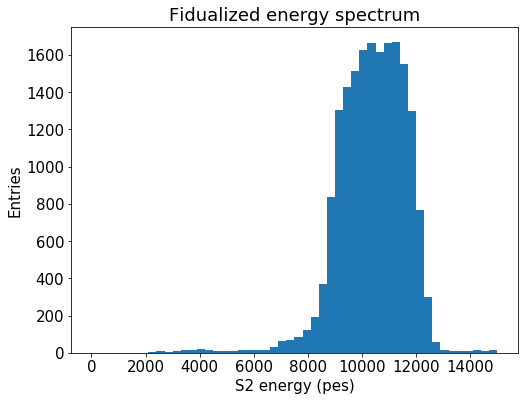

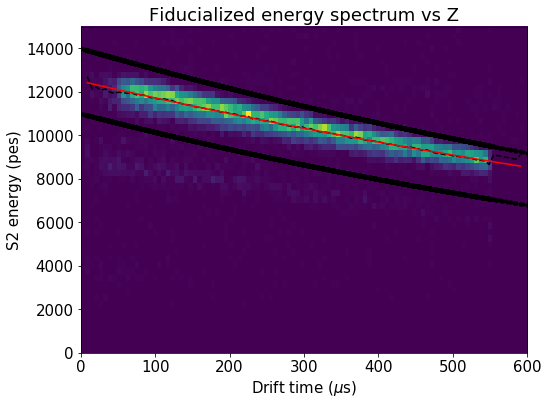

In [7]:
hist(fid.S2e, 50, range=Erange_raw)
labels("S2 energy (pes)", "Entries", "Fidualized energy spectrum")
save("Raw_energy_fiducial")

low_cut   = 11000 * np.exp(-0.0008*fid.Z.values)
high_cut  = 14000 * np.exp(-0.0007*fid.Z.values)
sel       = coref.in_range(fid.S2e.values, low_cut, high_cut) # remove low and high E background

hist2d(fid.Z, fid.S2e, (100, 50), range=(Zrange, Erange_raw))
x, y, u_y = fitf.profileX(fid.Z[sel], fid.S2e[sel], 100, xrange=Zrange, yrange=Erange_raw)

plt.plot(x, y, profOpt)
plt.plot(fid.Z.values,  low_cut, "k.")
plt.plot(fid.Z.values, high_cut, "k.")

seed = np.max(y), (x[15] - x[5])/np.log(y[15]/y[5])
f    = fitf.fit(fitf.expo, x, y, seed, fit_range=Zrange_LT, sigma=u_y)

plt.plot(x, f.fn(x), fitOpt)
print("Energy at z=0 = {:.1f} +- {:.1f}".format( f.values[0], f.errors[0]))
print("Lifetime      = {:.1f} +- {:.1f}".format(-f.values[1], f.errors[1]))
print("Chi2          = {:.2f}          ".format(f.chi2))

labels("Drift time ($\mu$s)", "S2 energy (pes)", "Fiducialized energy spectrum vs Z")
save("Raw_energy_vsZ_fiducial")

Zcorr = corrf.LifetimeCorrection(-f.values[1], f.errors[1])

(10000.0, 12000, 200)
oficial: 2.28496565803e+93
tonte  : 2.28496565803e+93
[  1532.44515143  11763.76364516    354.8710868 ]
[ 604.44968007  161.6622461   161.66224933]
ok
(10000.0, 11900, 200)
oficial: 1.49156125121e+128
tonte  : 1.49156125121e+128
[  9355.56622419  11772.43736981    316.86646564]
[ 1465.65443054    57.31810304    57.31810407]
ok
(10000.0, 11800, 200)
oficial: 5.39455443829e+166
tonte  : 5.39455443829e+166
[ 27112.75413352  11692.06751481    274.12021018]
[ 2751.79292298    32.1273469     32.12734754]
ok
(10000.0, 11700, 200)
oficial: 1.36997243861e+187
tonte  : 1.36997243861e+187
[ 66447.15976652  11662.06177707    253.5060106 ]
[ 3043.67305581    13.40860421    13.40860446]
ok
(10000.0, 11600, 200)
oficial: 4.85398304879e+196
tonte  : 4.85398304879e+196
[ 121102.31776013   11604.29157875     249.98702988]
[ 3171.64698019     7.55986821     7.55986834]
ok
(10000.0, 11500, 200)
oficial: 7.21543489848e+229
tonte  : 7.21543489848e+229
[ 168553.98597242   11544.47301816

(10000.0, 7400, 200)
oficial: 1.83184221254e+165
tonte  : 1.83184221254e+165
[ 122114.88668493    8597.74457899     264.33971684]
[ 1786.4041573      4.46522511     4.46522515]
ok
(10000.0, 7300, 200)
oficial: 8.56523636888e+138
tonte  : 8.56523636888e+138
[ 126903.85213448    8512.79374988     263.90625563]
[ 1681.98953421     4.03893696     4.03893701]
ok
(10000.0, 7200, 200)
oficial: 6.39970382402e+138
tonte  : 6.39970382402e+138
[ 100308.71364253    8452.30334521     279.75374277]
[ 1722.19142514     5.54611406     5.54611414]
ok


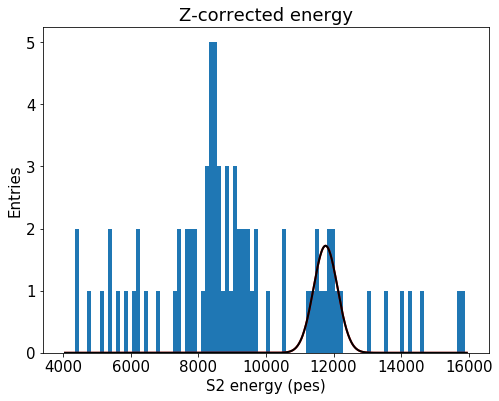

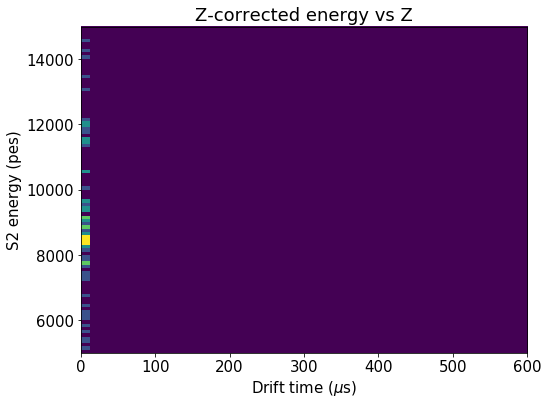

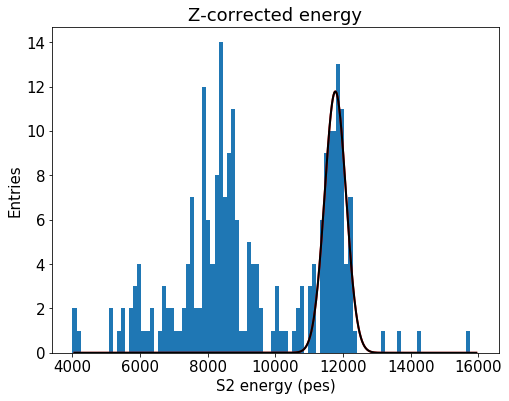

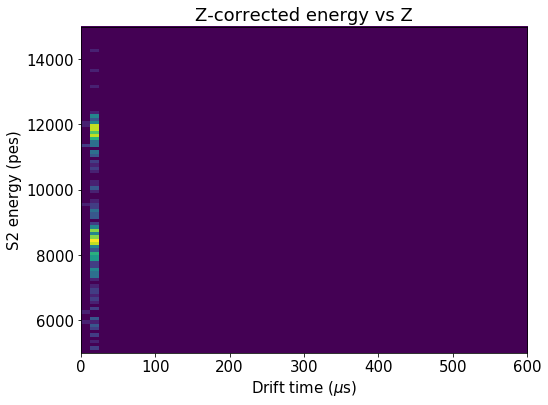

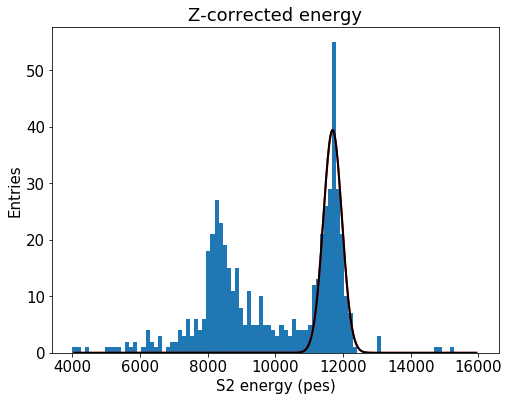

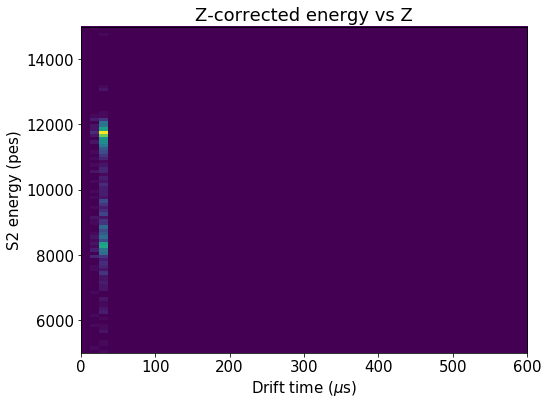

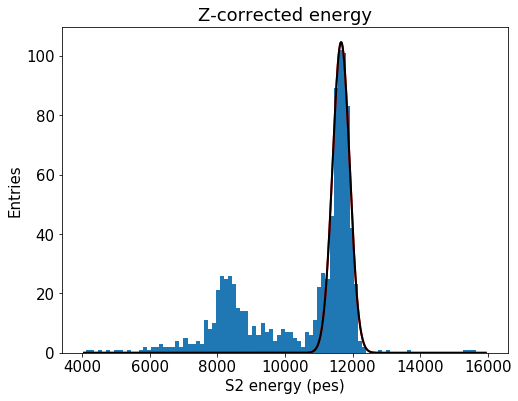

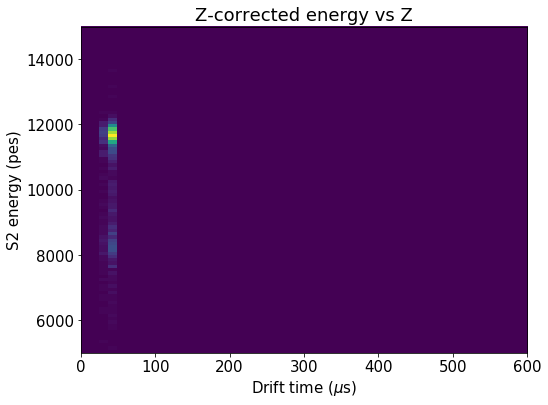

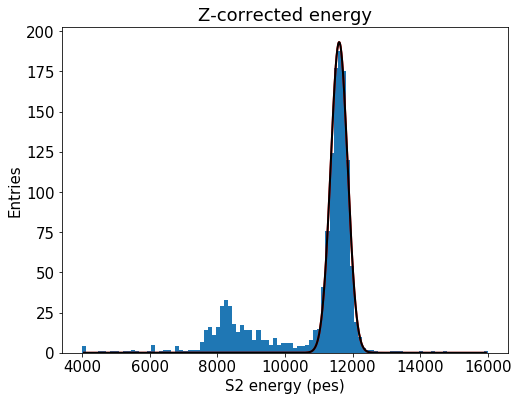

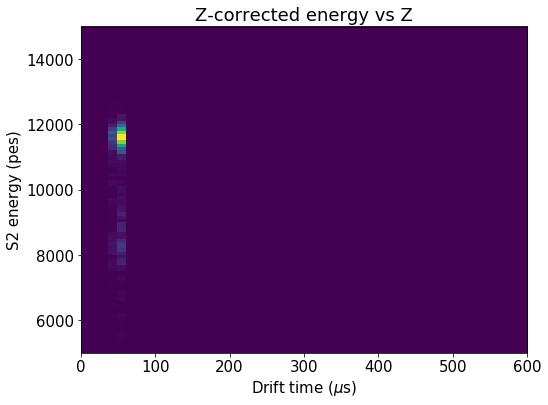

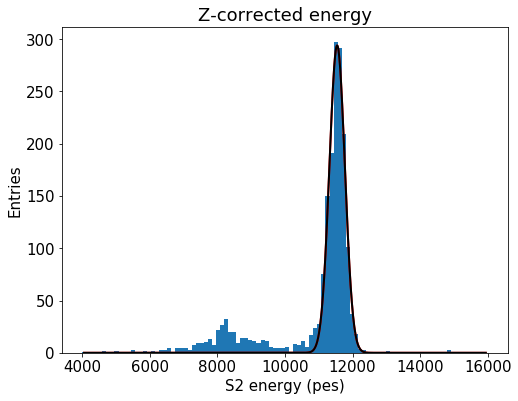

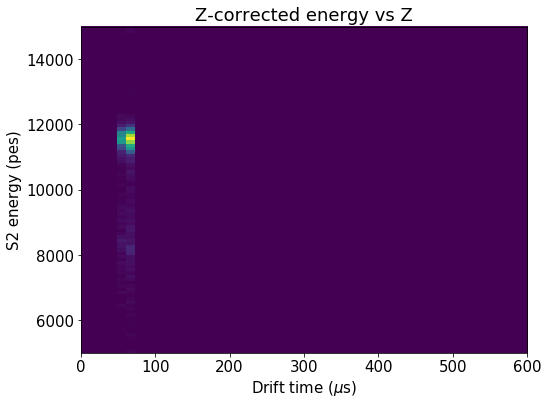

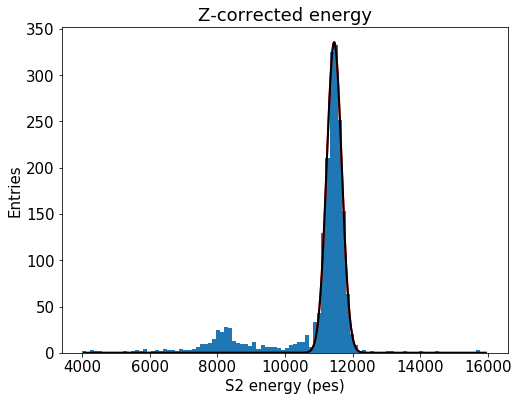

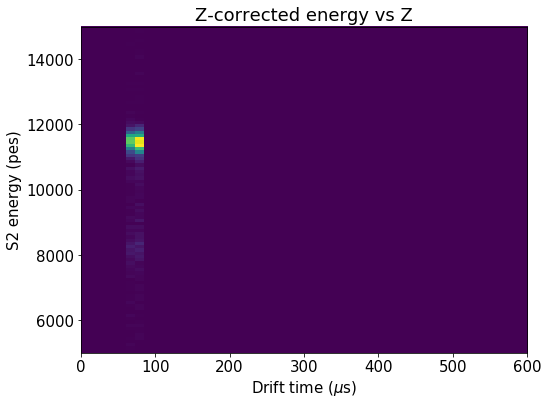

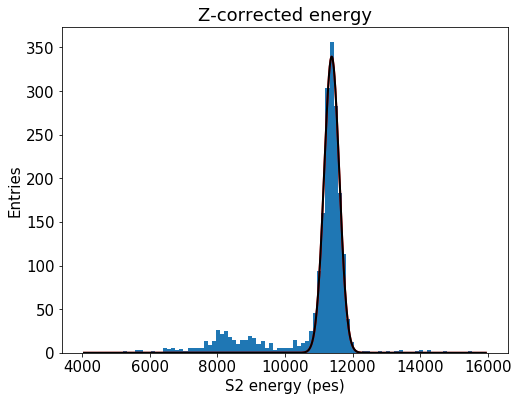

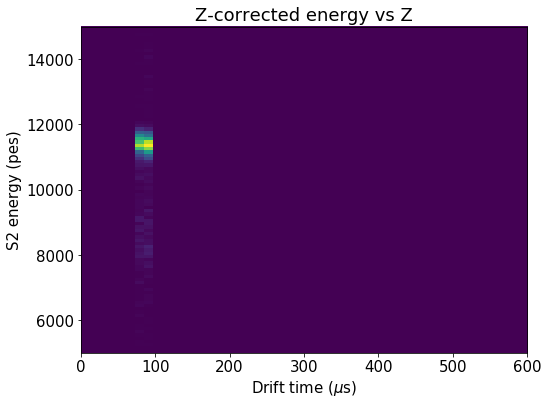

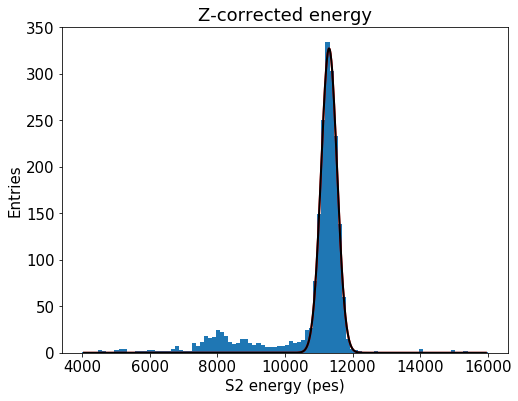

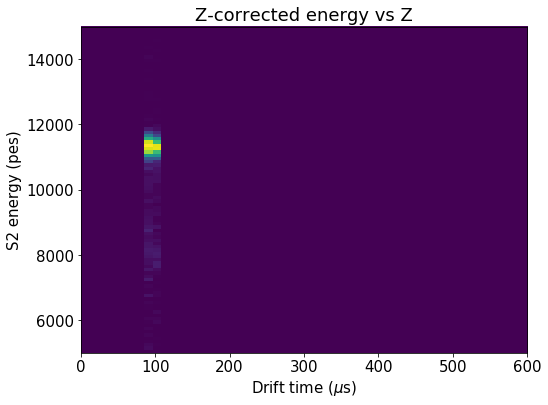

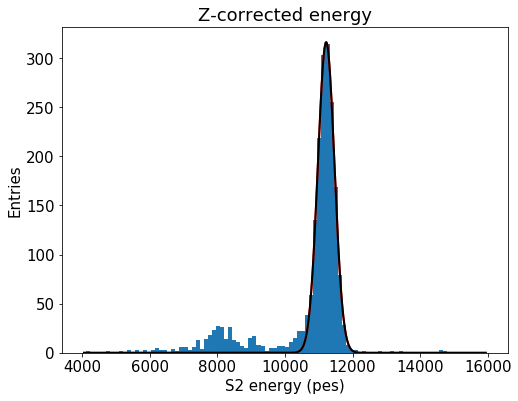

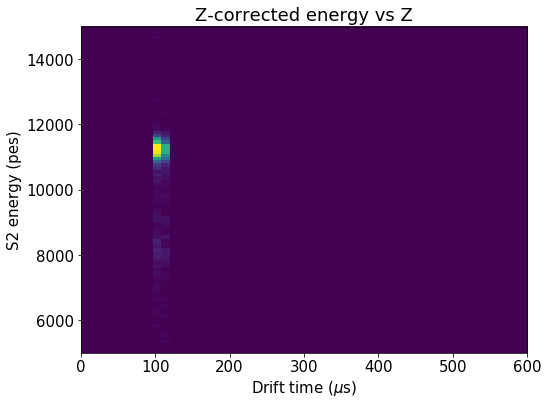

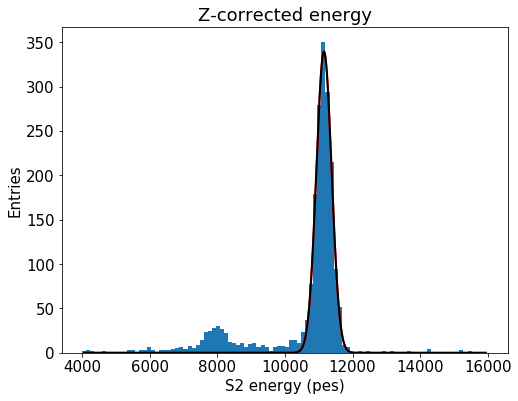

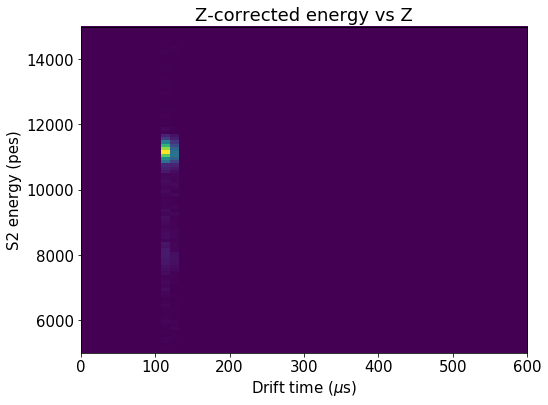

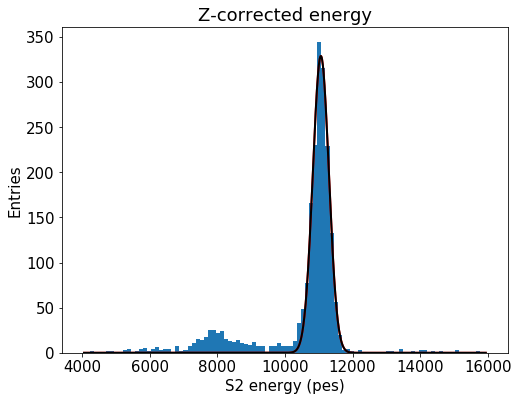

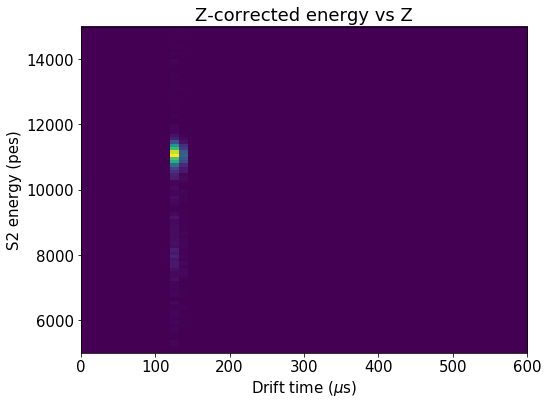

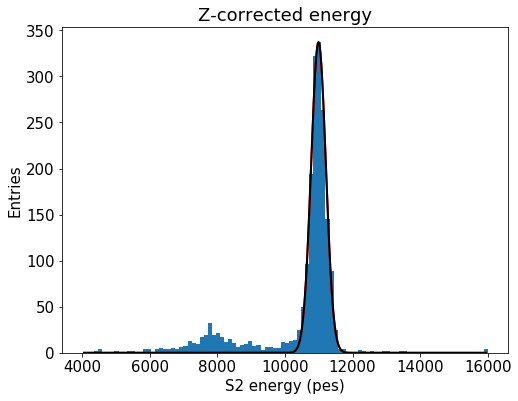

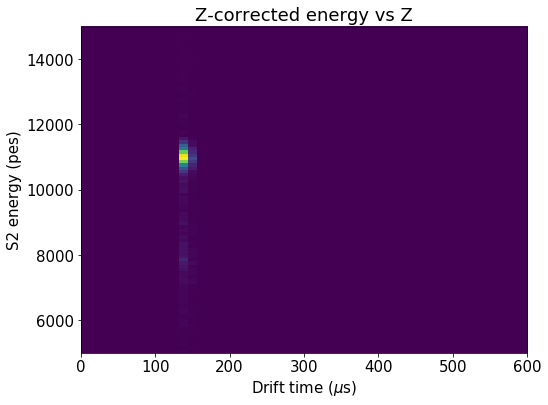

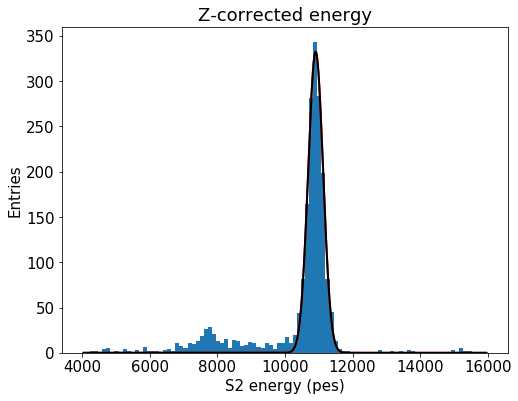

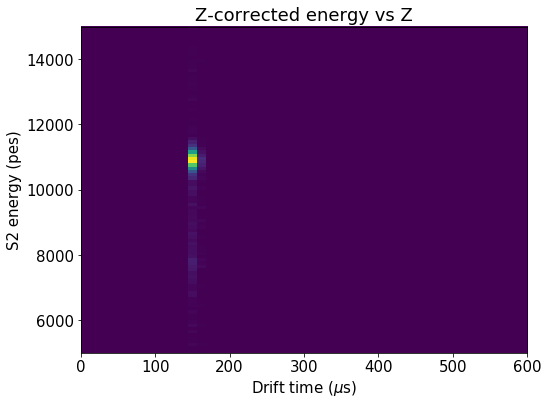

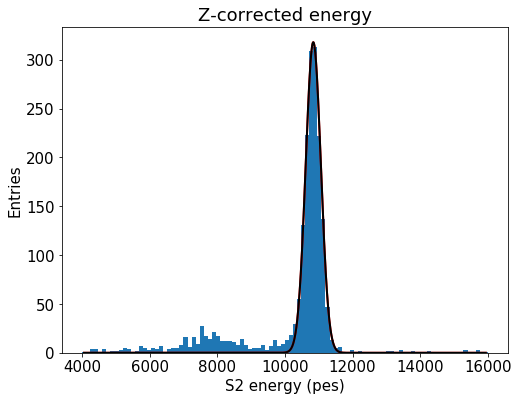

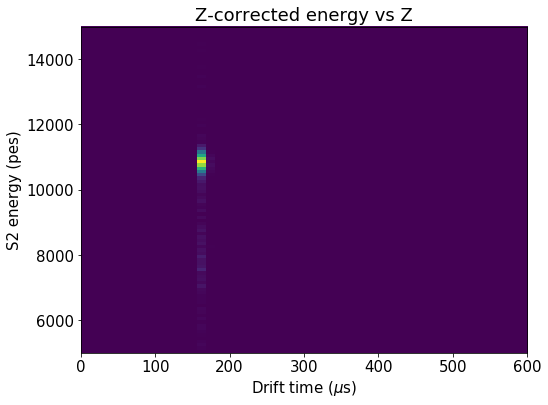

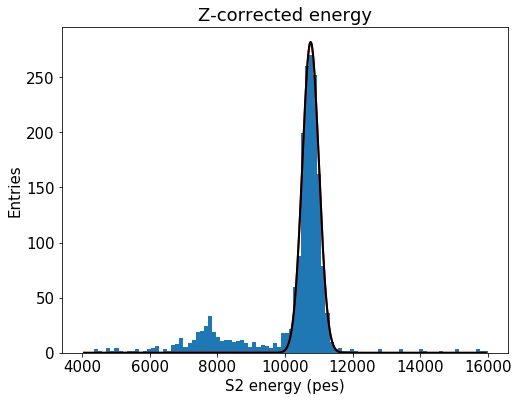

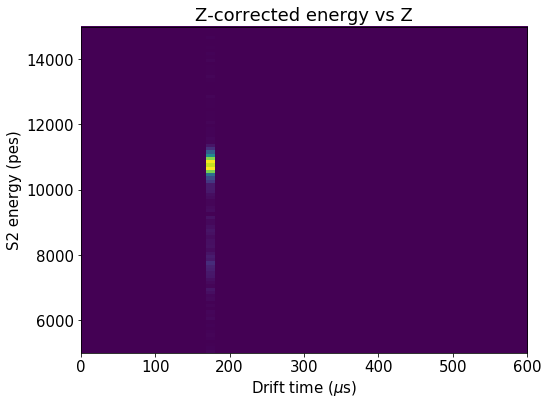

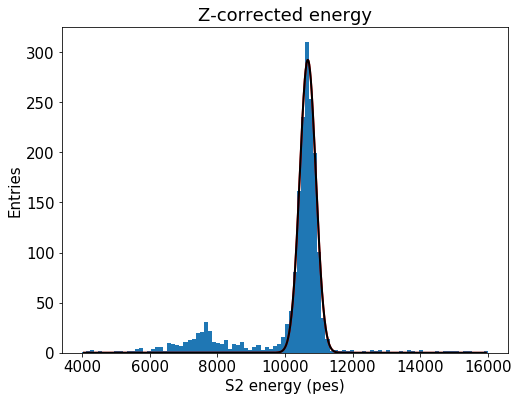

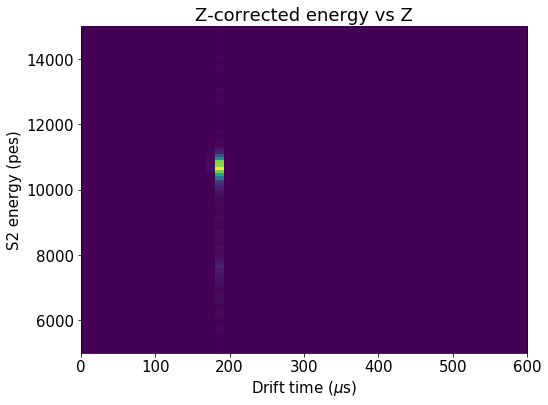

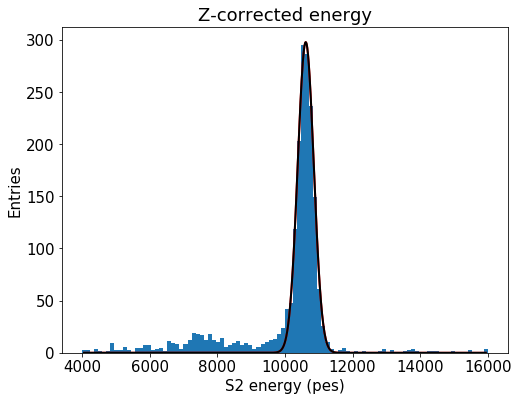

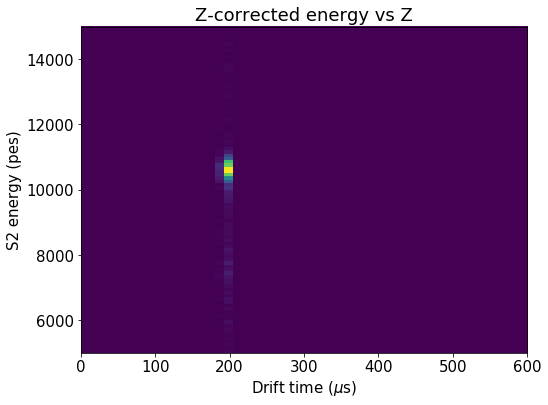

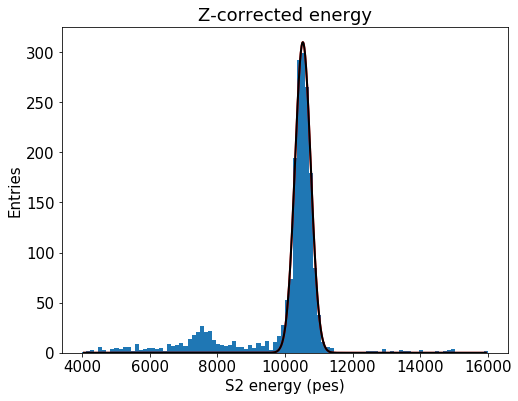

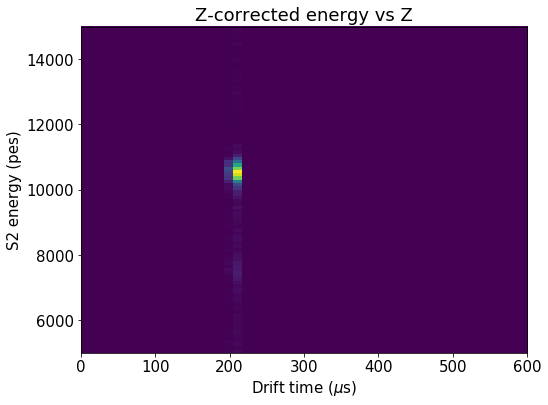

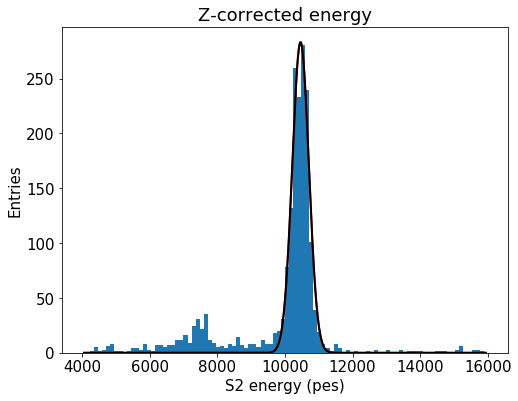

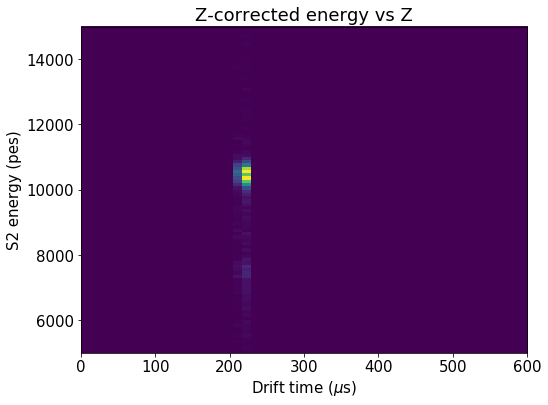

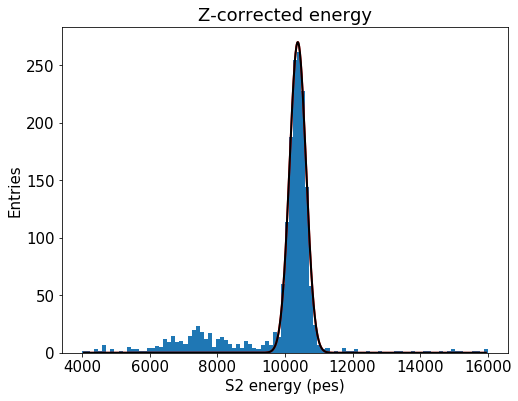

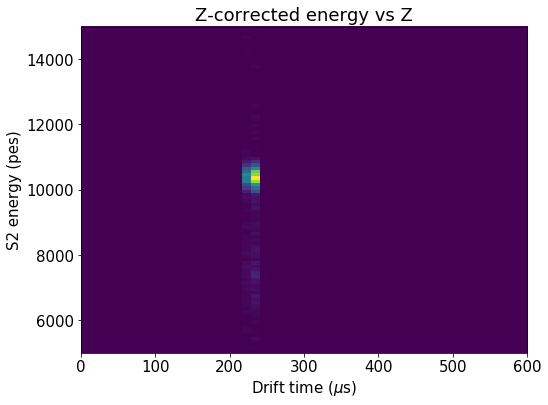

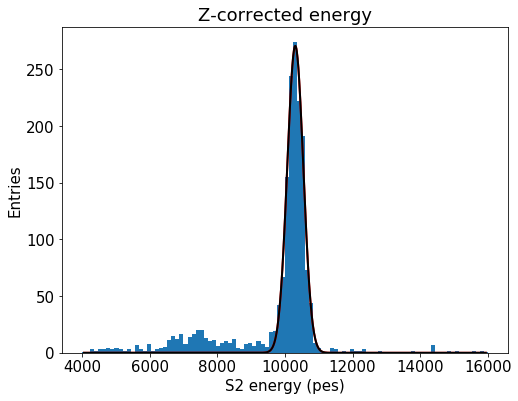

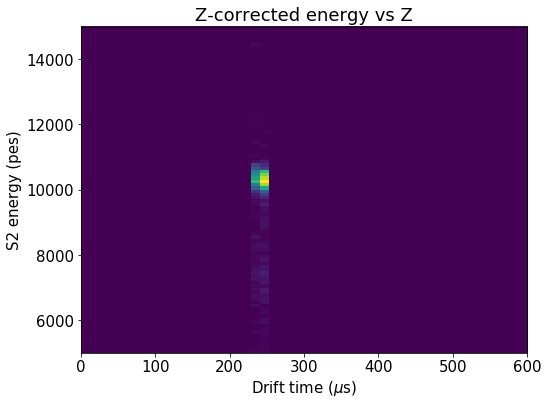

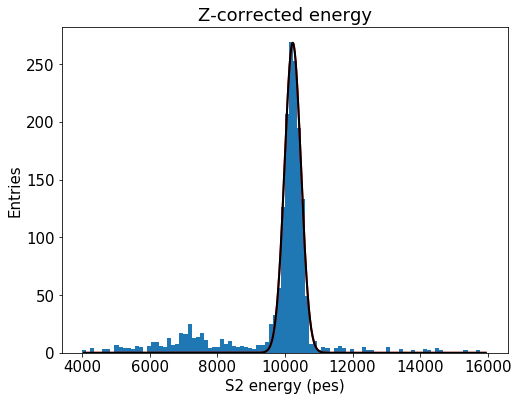

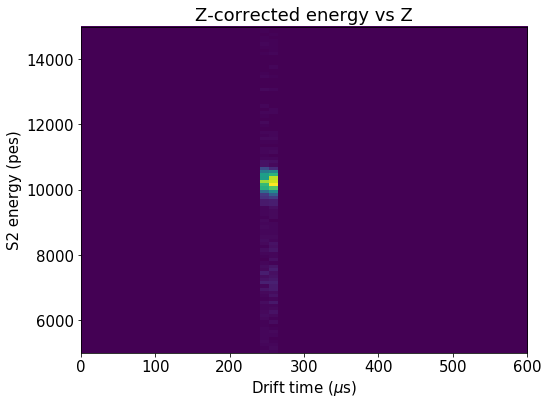

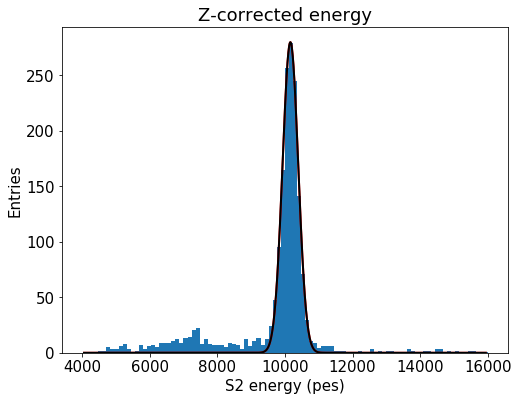

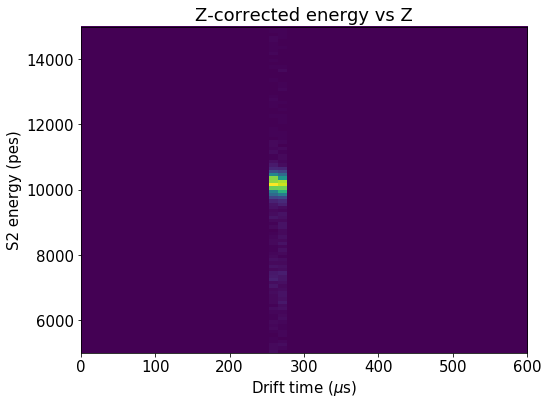

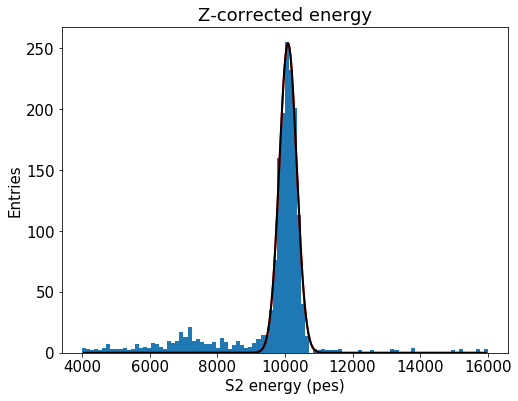

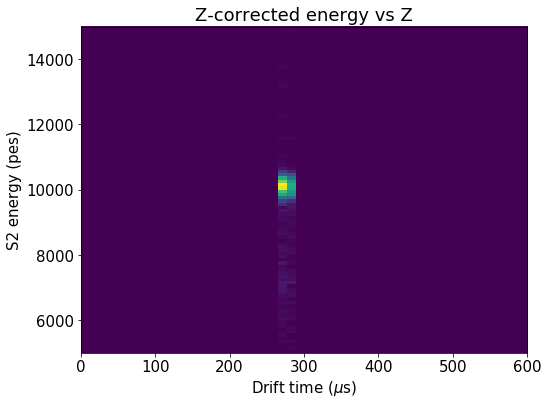

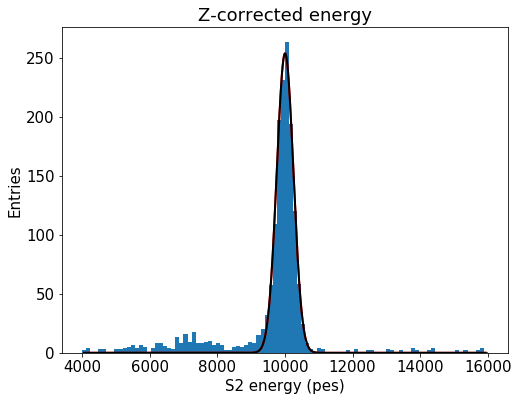

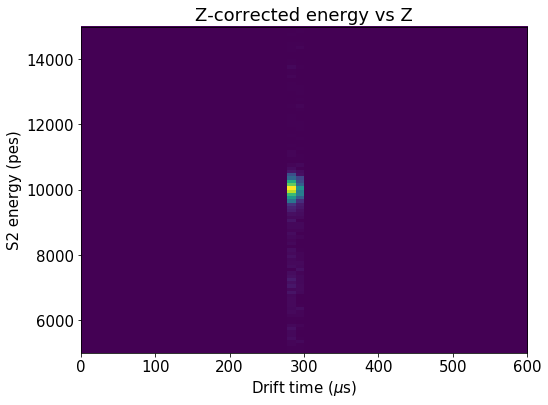

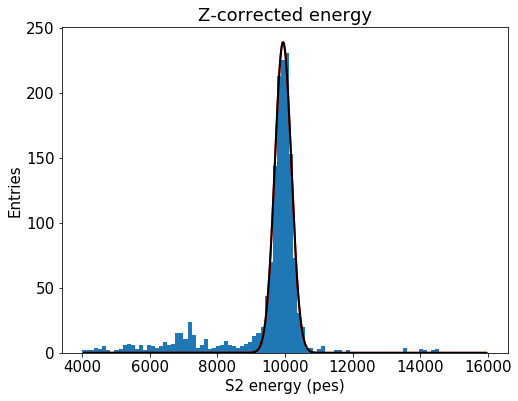

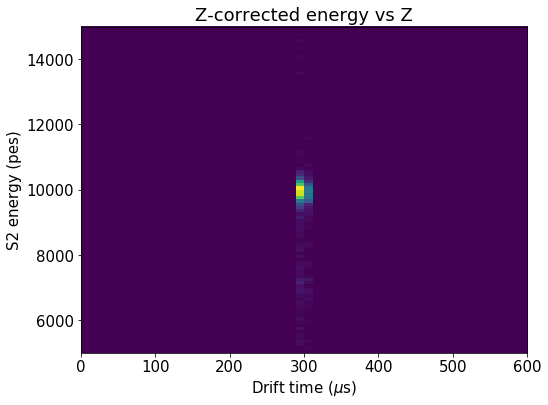

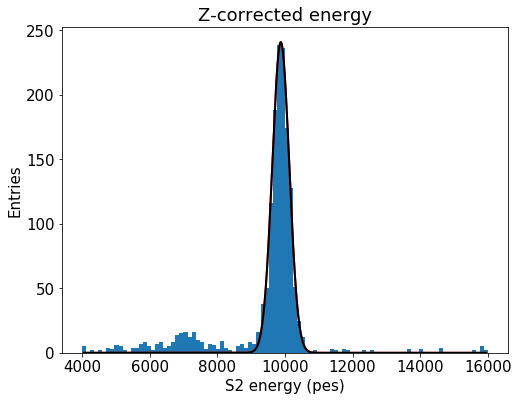

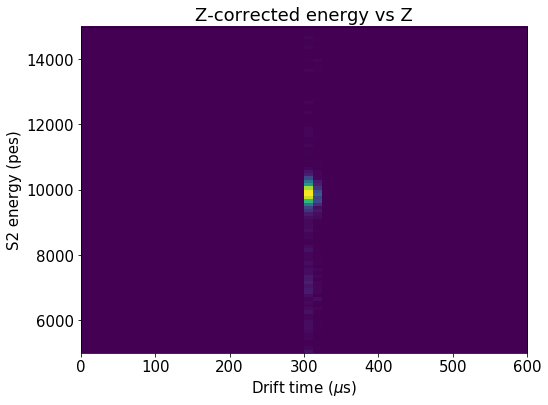

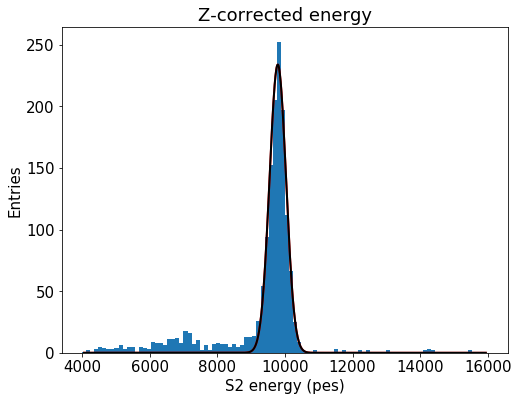

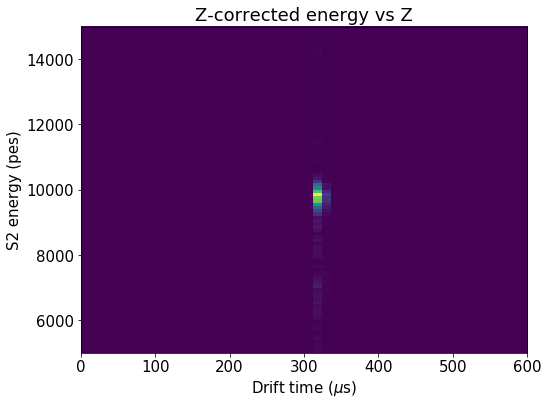

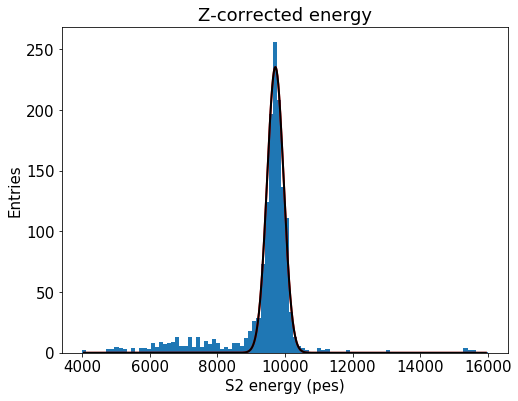

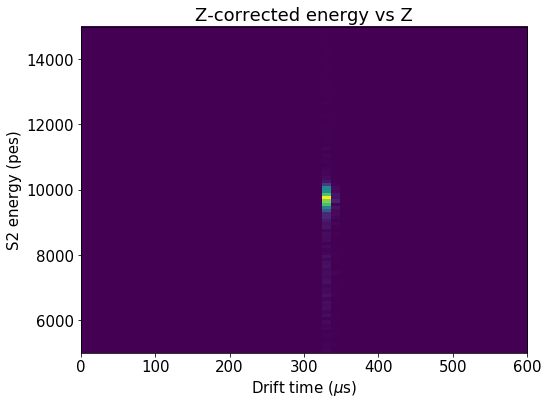

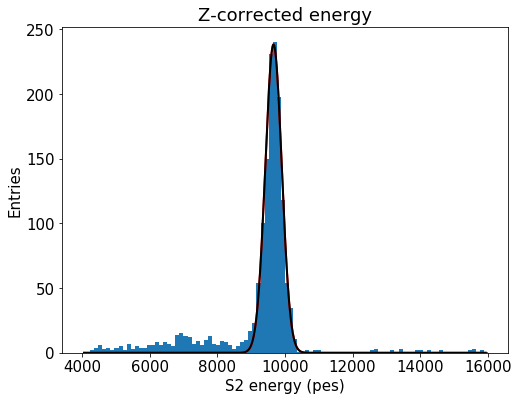

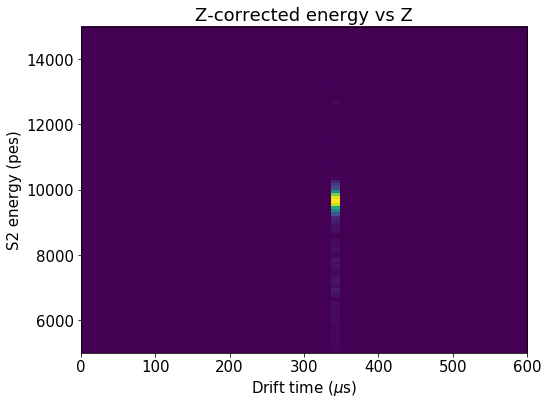

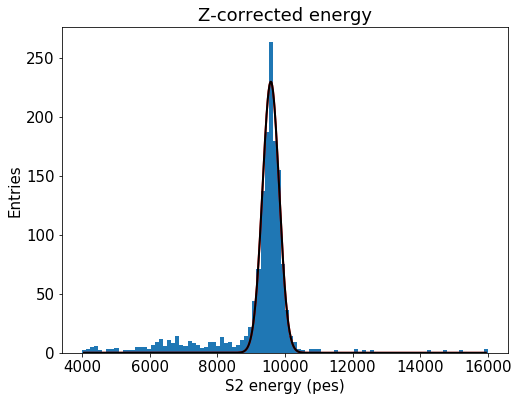

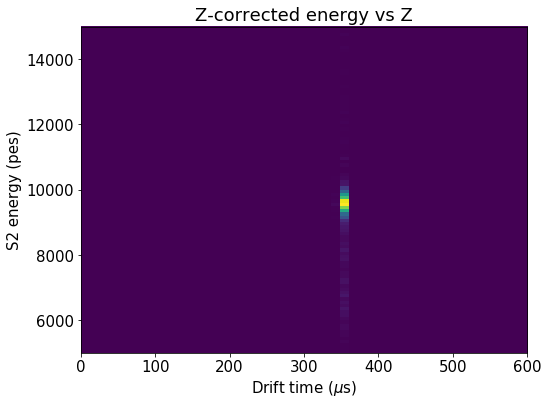

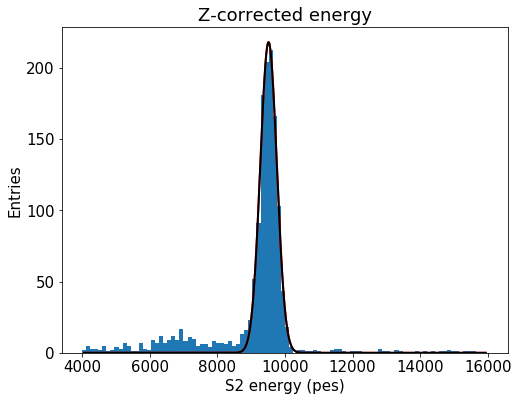

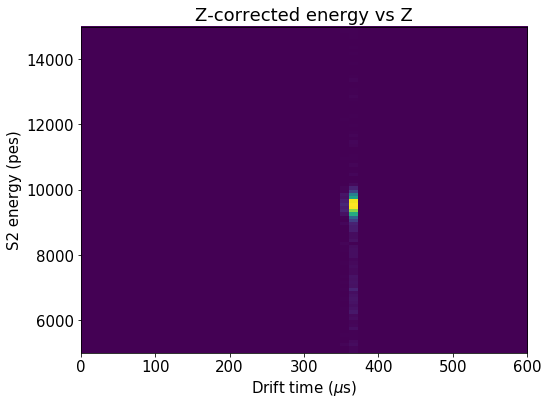

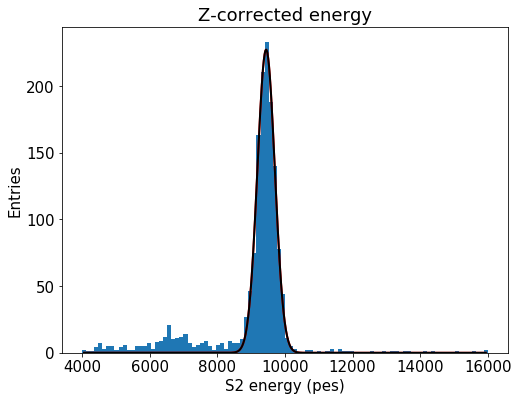

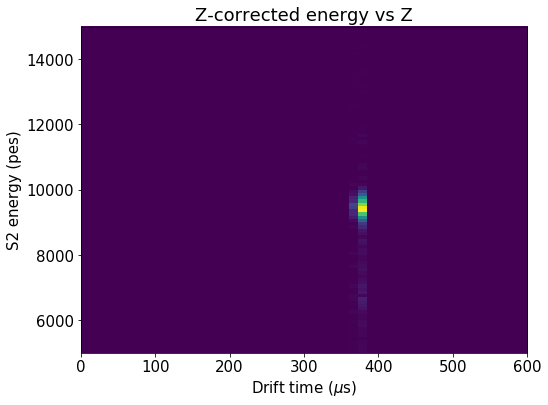

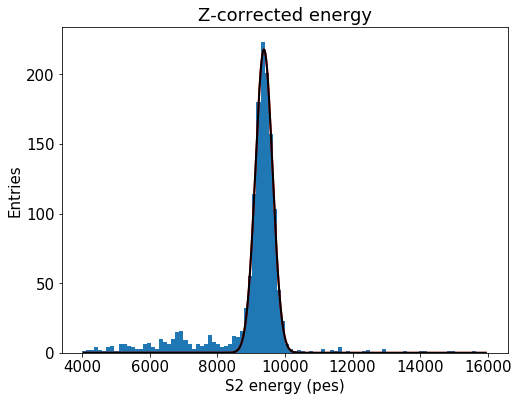

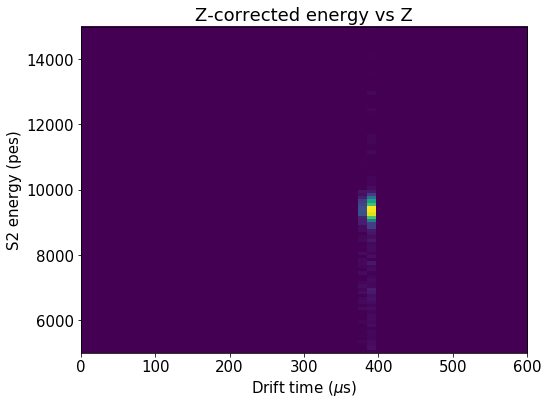

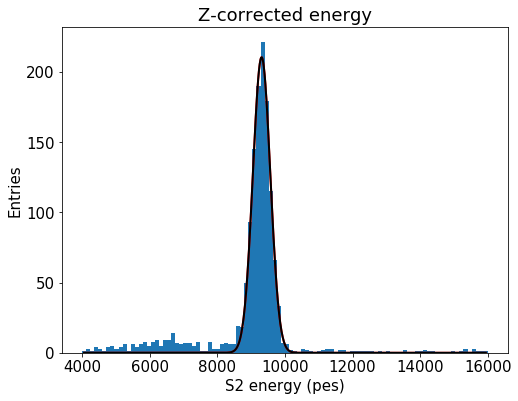

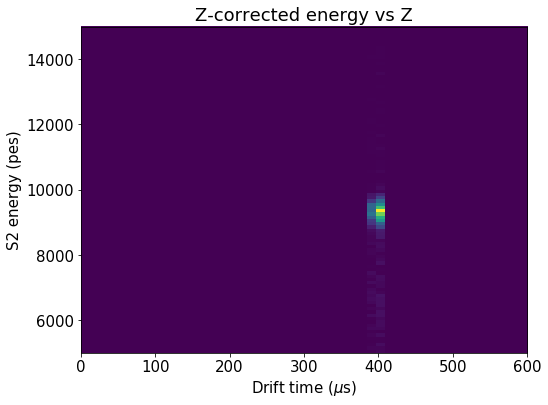

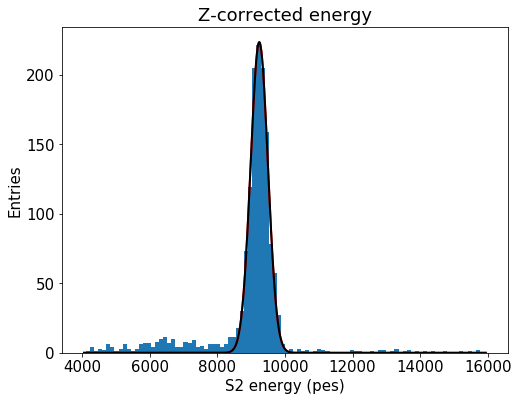

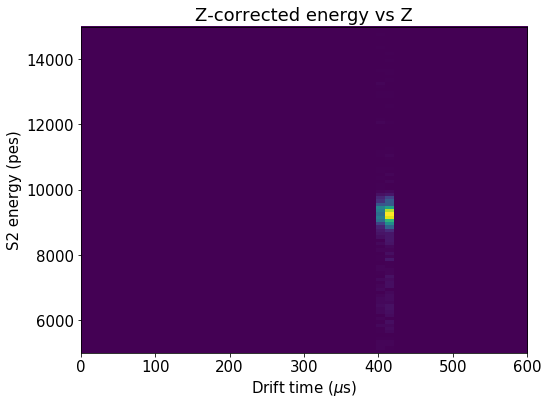

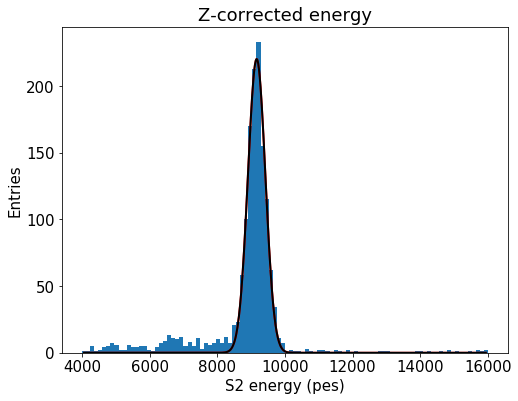

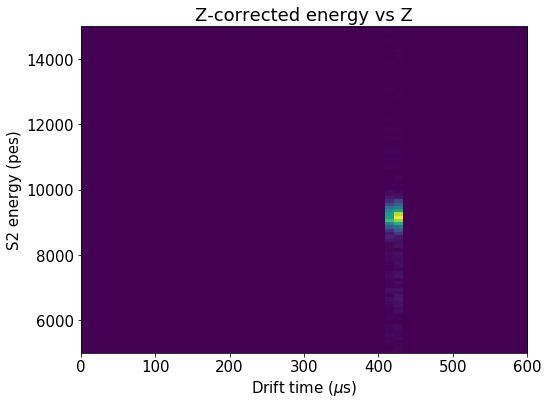

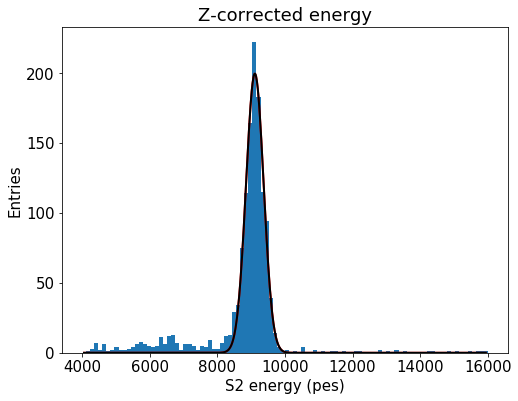

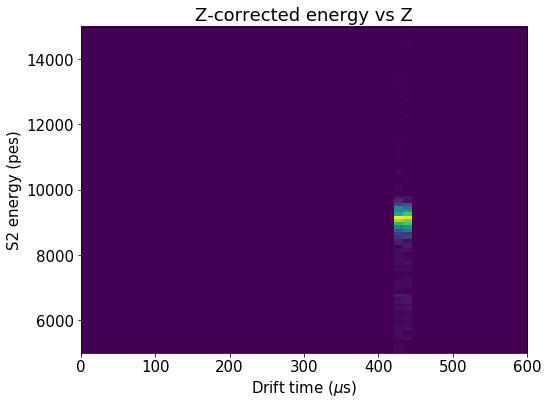

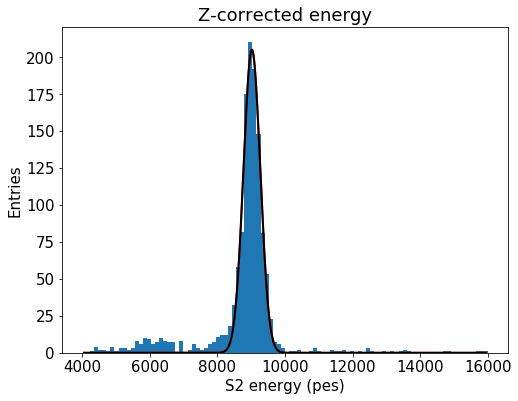

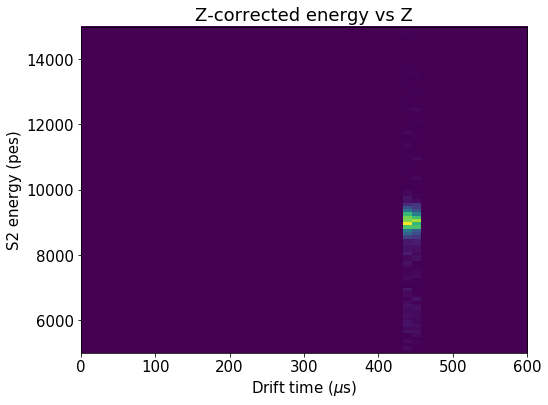

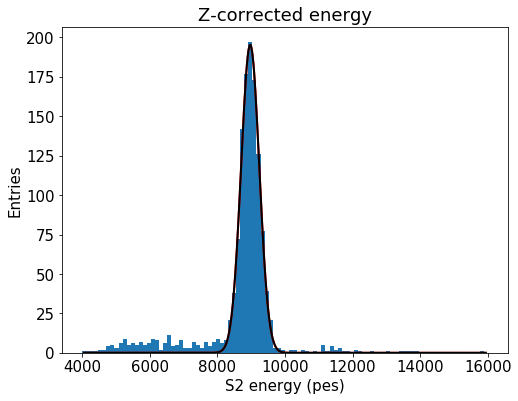

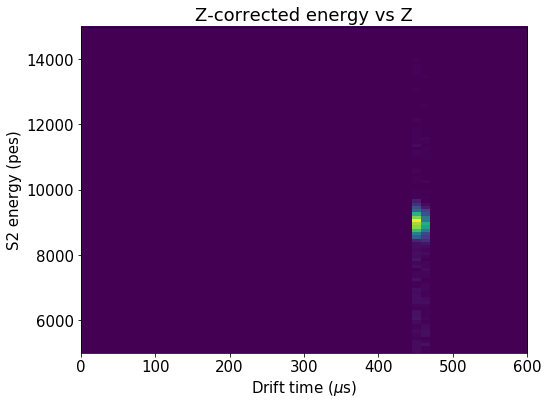

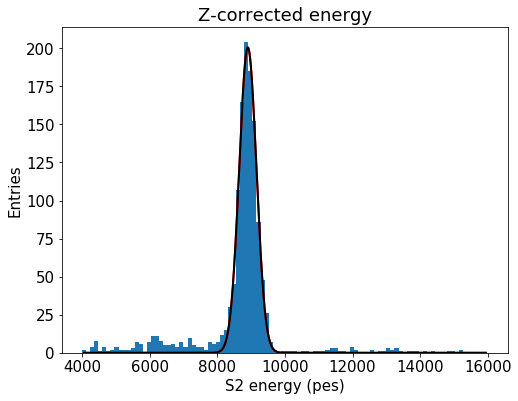

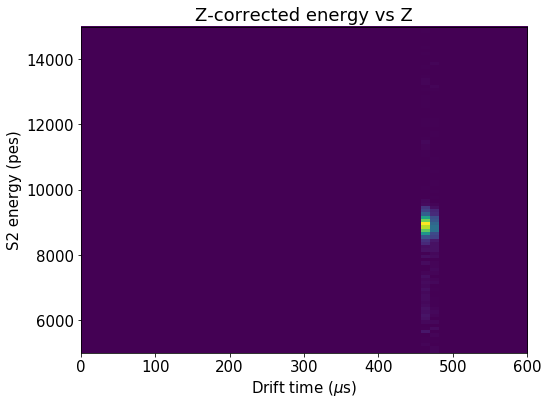

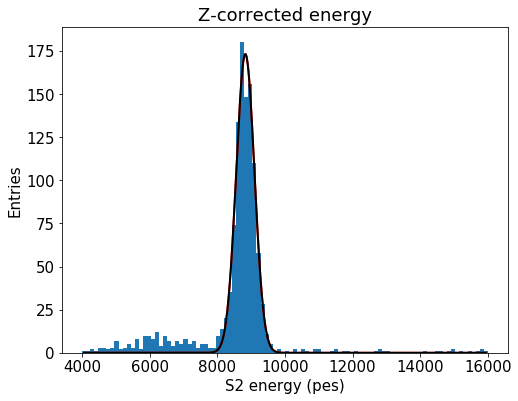

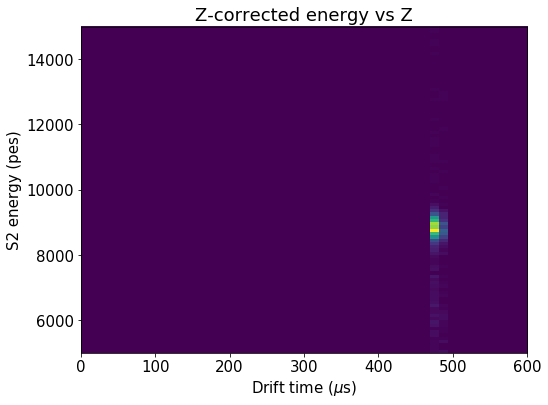

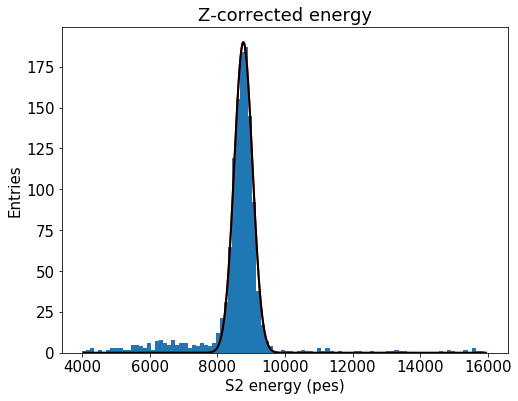

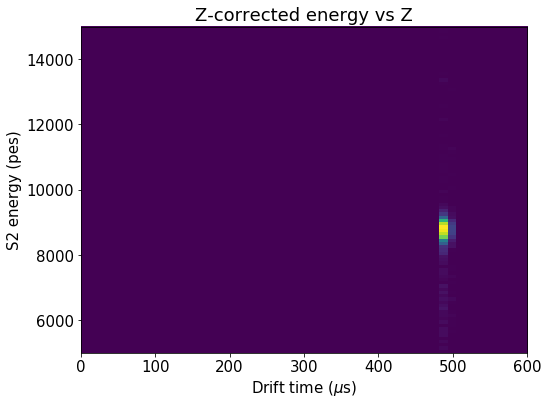

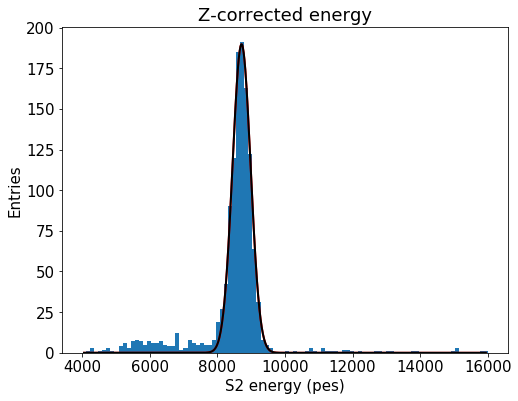

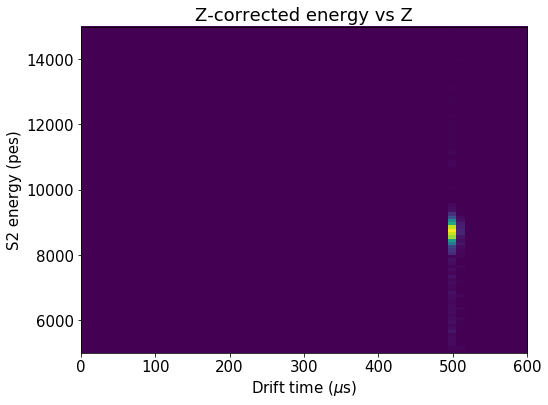

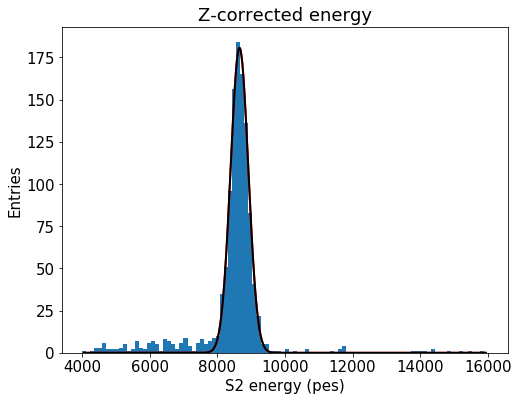

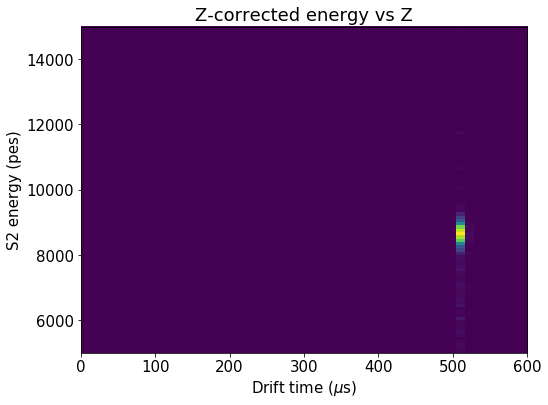

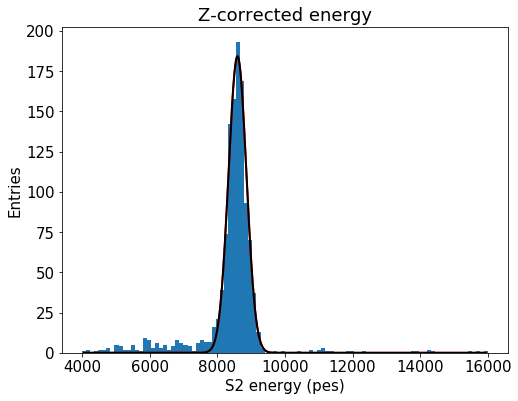

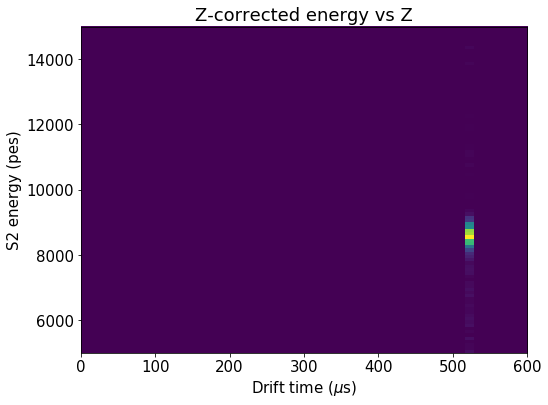

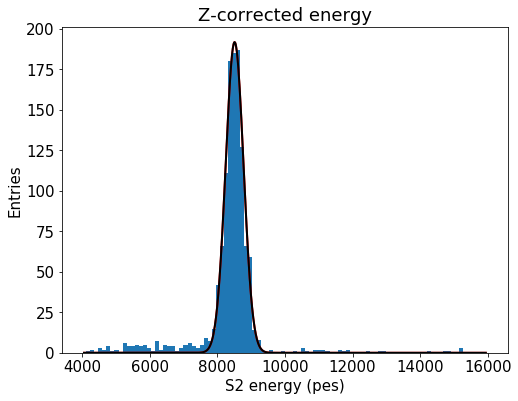

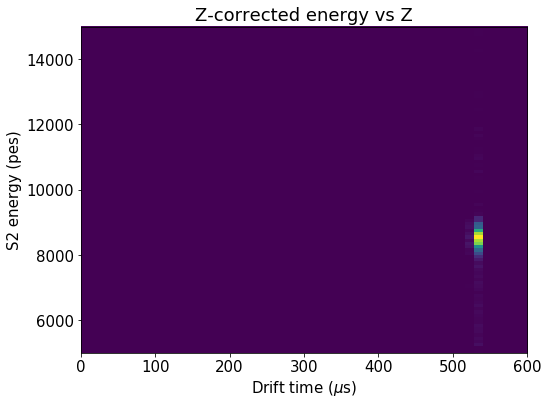

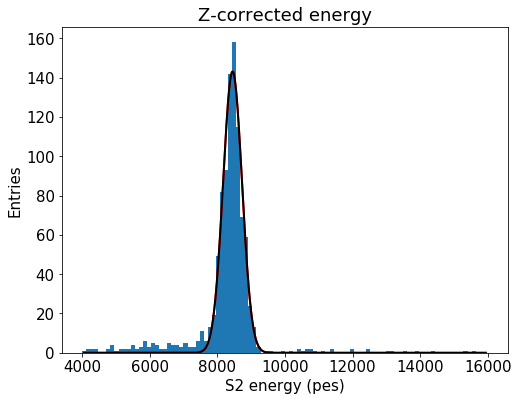

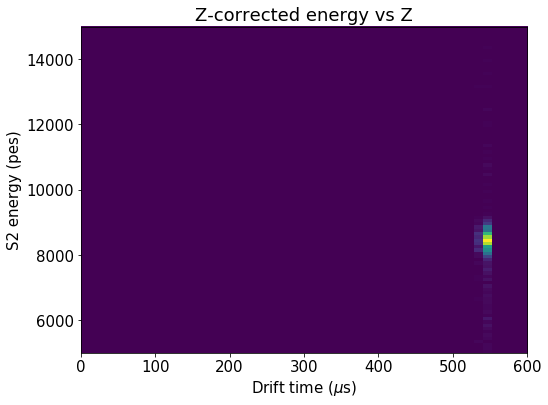

In [9]:
data = full
Zbins = np.linspace(0, 550,50)
step = 100
Z_drift_data = []
for i in range(len(Zbins)-1):
    data_   = data[fitf.in_range(data.Z.values, Zbins[i], Zbins[i+1])]
    E_zcorr = data_.S2e.values * xy_map(data_.X.values, data_.Y.values).value
    y, x, _ = hist(E_zcorr, 100, range=[4e3, 16e3])

    seed = 1e4,  12000-i*step, 200#, 1e3,  9500-i*step, 200, 10
    low  =  10,  7000-i*step,  50, 1e2,  8500-i*step,  50, 0 
    upp  = 1e8, 10000-i*step, 400, 1e5, 11000-i*step, 900, 100
    print (seed)
    
    f    = fitf.fit(fitf.gauss, x, y, seed, fit_range=(4e3,16e3))
    print(f.values)
    print(f.errors)


    xrange = np.linspace(x[0], x[-1],1000)


    plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "r-", linewidth=2)
    #plt.plot(xrange, fitf.gauss(xrange, *f.values[3:-1]), linewidth=2)
    #plt.plot(xrange, f.values[-1]*np.ones_like(xrange), linewidth=2)
    plt.plot(xrange, f.fn(xrange), "k-", linewidth=2)
    #plt.text(Erange_zcorr[0]+1e3, 1*max(y)/4, gausstext(f.values, 30), color=fitOpt)

    labels("S2 energy (pes)", "Entries", "Z-corrected energy")
    save("S2energyCorr_fiducial")

    hist2d(data_.Z.values, E_zcorr, (50, 100), range=(Zrange, Erange_zcorr))
    labels("Drift time ($\mu$s)", "S2 energy (pes)", "Z-corrected energy vs Z")

    Z_drift_data.append([f.values[1],f.errors[1]])
    print('ok')
    #save("S2energyCorrvsZ_fiducial")


oficial: 0.34664586994
tonte  : 0.34664586994
Energy at z=0 = 12037.0 +- 4.2
Lifetime      = 1548.7 +- 2.5
Chi2          = 0.01          
14.1190202938


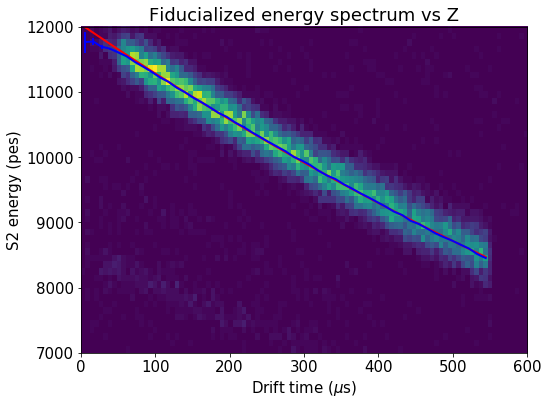

In [17]:
data = fid
E_z = data.S2e *xy_map(data.X.values, data.Y.values).value
hist2d(data.Z, E_z, (100, 50), range=(Zrange, [7e3,12e3]))

x, y, u_y = map(np.array, [Zbins, *zip(*Z_drift_data)])
x = (x+(x[1]-x[0])/2)[:-1]

plt.errorbar(x, y, yerr=u_y, fmt='b', linewidth=2)#, profOpt)

seed = 9000,-981#np.max(y), (x[15] - x[5])/np.log(y[15]/y[5])
f    = fitf.fit(fitf.expo, x, y, seed, fit_range=(75,540), sigma=u_y)

plt.plot(x, f.fn(x), c='r', linewidth=2)
print("Energy at z=0 = {:.1f} +- {:.1f}".format( f.values[0], f.errors[0]))
print("Lifetime      = {:.1f} +- {:.1f}".format(-f.values[1], f.errors[1]))
print("Chi2          = {:.2f}          ".format(f.chi2))

labels("Drift time ($\mu$s)", "S2 energy (pes)", "Fiducialized energy spectrum vs Z")
save("S2energyvsZ_fiducial")

Zcorr = corrf.LifetimeCorrection(-f.values[1], f.errors[1])
Zcorr_2 = corrf.Correction((x,), y, u_y, "max")

print(np.sum((y[(x>75)&(x<500)]-f.fn(x)[(x>75)&(x<500)])**2/u_y[(x>75)&(x<500)])/(len(x)-2))

# Lifetime scan

In [ ]:
x0, y0, r0 = 40, -40, 15
sel  = ((full.X - x0)**2 +
        (full.Y - y0)**2) < r0**2
data = full[sel]

low_cut   = 12000 * np.exp(-0.0010*data.Z.values)
high_cut  = 14000 * np.exp(-0.0008*data.Z.values)
sel       = coref.in_range(data.S2e.values, low_cut, high_cut) # remove low and high E background

Z = data.Z  .values[sel]
E = data.S2e.values[sel]
x, y, u_y = fitf.profileX(Z, E, 100, xrange=Zrange, yrange=Erange_raw)
f = fitf.fit(fitf.expo, x, y, (13e3, -1e3), fit_range=(50, 400), sigma=u_y)

hist2d(data.Z, data.S2e, 100, (Zrange, Erange_raw))
plt.plot(x, y, profOpt)
plt.plot(x, f.fn(x),  fitOpt)
plt.plot(data.Z.values,  low_cut, "k.")
plt.plot(data.Z.values, high_cut, "k.")

labels("Drift time (µs)", "S2 energy")


lts   = np.linspace(-f.values[1] - 5*f.errors[1],
                    -f.values[1] + 5*f.errors[1],
                    20)
sigs  = (lts + f.values[1]) / f.errors[1] 
res   = np.zeros_like(lts)
u_res = np.zeros_like(lts) 
for i in range(len(lts)):
    Ecorr    = E * np.exp(Z/lts[i])
    y, x     = np.histogram(Ecorr, 50, (11e3, 15e3))
    x        = shift_to_bin_centers(x)
    f        = fitf.fit(fitf.gauss, x, y, (1e5, 13e3, 1e2), fit_range=(12500, 13500), sigma=y**0.5)
    R        = resolution(f.values, f.errors)[0]
    res[i]   = R.value
    u_res[i] = R.uncertainty

plt.figure()
plt.errorbar(lts, res, u_res)
labels("Lifetime (µs)", "Resolution")

res_ticks = plt.yticks()[0]
xax = plt.gca().twiny()
yax = plt.gca().twinx()


xax.set_xlim(min(sigs), max(sigs))
xax.set_xticks(range(-5,6,2))
xax.set_xlabel("Deviation from fit (#$\sigma$)")

scale = (41.5/2458)**0.5
yax.set_ylim(min(res) * scale, max(res) * scale)
#yax.set_yticks(res_ticks * scale)
yax.set_ylabel("Resolution @ Qbb")

# Lifetime T dependence

In [ ]:
Z  = full.Z   .values
R  = full.R   .values
E  = full.S2e .values
T  = full.time.values
T -= T.min()
T /= 3600 # time in hours

nbins  = 12
tbins  = np.linspace(0, T.max(), nbins + 1)

nx, ny = 4, 3

LT     = np.zeros(nbins)
u_LT   = np.zeros(nbins)

Trange = 0, T.max()
plt.figure(figsize=(6*nx, 6*ny))
for i in range(nbins):
    sel_r = R < 100
    sel_t = coref.in_range(E, *Erange_raw) & coref.in_range(T, *tbins[i:i+2])
    
    plt.subplot(nx, ny, i+1)
    n, x, y, _ = \
    hist2d(Z[sel_r & sel_t], E[sel_r & sel_t], (40, 50), (Zrange, Erange_raw), new_figure=False)
    labels("Drift time (µs)", "S2 energy (pes)", "{:.0f} - {:.0f} mm".format(*tbins[i:i+2]))

    low_cut   = 12000 * np.exp(-0.0010*Z)
    high_cut  = 14000 * np.exp(-0.0008*Z)
    sel_E     = coref.in_range(E, low_cut, high_cut) # remove low and high E background

    x, y, u_y = fitf.profileX(Z[sel_r & sel_t & sel_E], E[sel_r & sel_t & sel_E], 100)
    plt.errorbar(x, y, u_y, fmt="*m")

    seed = np.max(y), (x[15] - x[5])/np.log(y[15]/y[5])
    f    = fitf.fit(fitf.expo, x, y, seed, fit_range=Zrange_LT, sigma=u_y)

    LT  [i] = -f.values[1]
    u_LT[i] =  f.errors[1]
plt.tight_layout()

dt    = np.diff(tbins) * 0.5
tbins = shift_to_bin_centers(tbins)

plt.figure()
plt.errorbar(tbins, LT, u_LT, dt, fmt="k*")

print("Lifetime's time effect of the order of {:.2f} %".format(100*(LT.max()/LT.min() - 1)))

labels("Time (h)", "Lifetime (µs)", "Lifetime vs time")
save("LifetimevsT_profile")

# Lifetime XY dependence

In [ ]:
rbins  = np.array([0, 40, 60, 80, 100, 115, 130, 140, 150, 160, 170, 180, 190])
nbins  = len(rbins) - 1
nx, ny = 4, 3

LT     = np.zeros(nbins)
u_LT   = np.zeros(nbins)

Z = full.Z  .values
R = full.R  .values
E = full.S2e.values

plt.figure(figsize=(6*nx, 6*ny))

for i in range(nbins):
    sel_r = coref.in_range(E, *Erange_raw) & coref.in_range(R, *rbins[i:i+2])
    
    plt.subplot(nx, ny, i+1)
    n, x, y, _ = \
    hist2d(Z[sel_r], E[sel_r], (40, 50), (Zrange, Erange_raw), new_figure=False)
    labels("Drift time (µs)", "S2 energy (pes)", "{:.0f} - {:.0f} mm".format(*rbins[i:i+2]))
    slice_max = np.argmax(n, axis=1)
    slice_ene = y[slice_max]
    slice_rms = [1.25*np.average((y-mean)**2, weights=w)**0.5 if np.any(w) else 0 for w, mean in zip(n, slice_ene)]
    
    plt.errorbar(x, slice_ene, slice_rms, fmt="*k")
    
    f_low = fitf.fit(fitf.expo, x, slice_ene-[2*i for i in slice_rms], (1e4, -500), fit_range=Zrange_LT)
    f_upp = fitf.fit(fitf.expo, x, slice_ene+[2*i for i in slice_rms], (1e4, -500), fit_range=Zrange_LT)
    
    plt.plot(x, f_low.fn(x), "r")
    plt.plot(x, f_upp.fn(x), "r")

    low_cut = f_low.fn(Z)
    upp_cut = f_upp.fn(Z)
    sel_E   = coref.in_range(E, low_cut, upp_cut) # remove low and high E background

    x, y, u_y = fitf.profileX(Z[sel_r & sel_E], E[sel_r & sel_E], 100, xrange=Zrange, yrange=Erange_raw)
    plt.errorbar(x, y, u_y, fmt="*m")

    seed = np.max(y), (x[55] - x[45])/np.log(y[55]/y[45])
    f    = fitf.fit(fitf.expo, x, y, seed, fit_range=Zrange_LT, sigma=u_y)

    LT  [i] = -f.values[1]
    u_LT[i] =  f.errors[1]
plt.tight_layout()

dr    = np.diff(rbins) * 0.5
rbins = rbins[:-1] + dr 
plt.figure()
plt.errorbar(rbins, LT, u_LT, dr, fmt="k*")

labels("R (mm)", "Lifetime (µs)", "Lifetime vs R")
save("LifetimevsR_profile")

In [ ]:
plot_all = False

nx, ny = 4,4
xbins  = np.linspace(*XYrange, nx+1)
ybins  = np.linspace(*XYrange, ny+1)
xybins = xbins, ybins

LT     = np.zeros((nx, ny))
u_LT   = np.zeros((nx, ny))

Z = full.Z  .values
X = full.X  .values
Y = full.Y  .values
E = full.S2e.values

if plot_all:
    plt.figure(figsize=(nx, ny))

for i in range(nx):
    for j in range(ny):
        sel_r = coref.in_range(E, *Erange_raw)\
              & coref.in_range(X, *xbins[i:i+2])\
              & coref.in_range(Y, *ybins[j:j+2])

        if np.count_nonzero(sel_r) < 100: continue

        if plot_all:
            plt.subplot(ny, ny, i*nx+j+1)
            n, x, y, _ = \
            hist2d(Z[sel_r], E[sel_r], (40, 50), (Zrange, Erange_raw), new_figure=False)
        n, x, y = \
        np.histogram2d(Z[sel_r], E[sel_r], (40, 50), (Zrange, Erange_raw))
        x = shift_to_bin_centers(x)
        y = shift_to_bin_centers(y)
        if plot_all:
            labels("Drift time (µs)", "S2 energy (pes)",
                   "X {:.0f} - {:.0f} mm; Y {:.0f} - {:.0f} mm".format(*xbins[i:i+2],
                                                                       *ybins[j:j+2]))
        slice_max = np.argmax(n, axis=1)
        slice_ene = y[slice_max]
        slice_rms = [1.25*np.average((y-mean)**2, weights=w)**0.5 if np.any(w) else 0 for w, mean in zip(n, slice_ene)]

        if plot_all:
            plt.errorbar(x, slice_ene, slice_rms, fmt="*k")

        f_low = fitf.fit(fitf.expo, x, slice_ene-slice_rms, (1e4, -500), fit_range=Zrange_LT)
        f_upp = fitf.fit(fitf.expo, x, slice_ene+slice_rms, (1e4, -500), fit_range=Zrange_LT)

        if plot_all:
            plt.plot(x, f_low.fn(x), "r")
            plt.plot(x, f_upp.fn(x), "r")

        low_cut = f_low.fn(Z)
        upp_cut = f_upp.fn(Z)
        sel_E   = coref.in_range(E, low_cut, upp_cut) # remove low and high E background

        x, y, u_y = fitf.profileX(Z[sel_r & sel_E], E[sel_r & sel_E], 100, xrange=Zrange, yrange=Erange_raw)

        if plot_all:
            plt.errorbar(x, y, u_y, fmt="*m")

        seed = np.max(y), (x[15] - x[5])/np.log(y[15]/y[5])
        f    = fitf.fit(fitf.expo, x, y, seed, fit_range=Zrange_LT, sigma=u_y)

        LT  [i,j] = -f.values[1]
        u_LT[i,j] =  f.errors[1]

if plot_all:
    plt.tight_layout()

_, cb = display_matrix(shift_to_bin_centers(xbins),
                       shift_to_bin_centers(ybins),
                       LT, vmin=800, vmax=1300)
cb.set_label("Lifetime (µs)")
labels("x (mm)", "y (mm)", "Lifetime vs XY")
save("LifetimevsXY")

_, cb = display_matrix(shift_to_bin_centers(xbins),
                       shift_to_bin_centers(ybins),
                       u_LT, vmin=0, vmax=30)
cb.set_label("Lifetime uncertainty(µs)")
labels("x (mm)", "y (mm)", "Lifetime uncertainty vs XY")
save("LifetimeUncertaintyvsXY")

plt.figure()
_x = np.repeat(shift_to_bin_centers(xbins), ny)
_y = np.tile  (shift_to_bin_centers(ybins), nx)
_r = (_x**2 + _y**2)**0.5
plt.errorbar(_r, LT.flatten(), u_LT.flatten(), fmt=".k")
plt.xlim(*Rrange)
plt.ylim(800, 1300)
labels("r (mm)", "Lifetime (µs)", "Lifetime vs R")
save("LifetimevsR")

# Correction by attachment

In [ ]:
E_zcorr    = full.S2e.values * Zcorr(full.Z.values).value

y, x, _ = hist(E_zcorr, 100, range=Erange_zcorr)

fun  = lambda x, *args: fitf.gauss(x, *args[ :3])
seed = 1e3, 12000, 100
low  =  10, 11000,  50
upp  = 1e8, 13000, 900
f    = fitf.fit(fun, x, y, seed, fit_range=(12400, 14000), bounds=(low, upp))

assert not np.any(np.isclose(f.values, seed))
assert not np.any(np.isclose(f.values, low ))
assert not np.any(np.isclose(f.values, upp ))

print("Resolution at 41.5 keV:", measurement_string(*resolution(f.values, f.errors, 41.5)[0]))
print("Resolution at 2458 keV:", measurement_string(*resolution(f.values, f.errors, 41.5)[1]))

plt.plot(x, f.fn(x), fitOpt)
plt.plot(x, fitf.gauss(x, *f.values),  fitOpt)
plt.text(Erange_zcorr[0] * 1.005, max(y)/2, gausstext(f.values, f.errors, 41.5))

labels("S2 energy (pes)", "Entries", "Z-corrected energy")
save("EcorrZ")

hist2d(full.Z.values, E_zcorr, (50, 100), range=(Zrange, Erange_zcorr))
labels("Drift time ($\mu$s)", "S2 energy (pes)", "Z-corrected energy vs Z")
save("EcorrZvsZ")

In [ ]:
low_cut   = 10500 *(1/(1 + np.exp((full.R.values-210)/20)))
high_cut  = 14000 *(1/(1 + np.exp((full.R.values-220)/20)))

hist2d  (full.R.values,  E_zcorr, (50, 100), range=(Rrange, Erange_zcorr))
plt.plot(full.R.values,  low_cut, ".k")
plt.plot(full.R.values, high_cut, ".k")
labels("R (mm)", "S2 energy (pes)", "Z-corrected energy vs R")
save("EcorrZvsR")

# Tracking

In [ ]:
hist(full.Nsipm, max(NSirange), NSirange)
labels("# SiPMs", "Entries", "Number of SiPMs touched")
save("Nsipm")

hist2d(full.Z, full.Nsipm, (30, max(NSirange)), range=(Zrange, NSirange))
x, y, _ = fitf.profileX(full.Z, full.Nsipm, 30, xrange=Zrange, yrange=NSirange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "# SiPMs", "Number of SiPMs touched vs Z")
save("NsipmvsZ")


# Kr distribution

In [ ]:
sel     = coref.in_range(E_zcorr, low_cut, high_cut)
Kr      = full   [sel]
E_zcorr = E_zcorr[sel]

In [ ]:
hist(Kr.X, 25, range=XYrange)
labels("x (mm)", "Entries", "X distribution")
save("X")

hist(Kr.Y, 25, range=XYrange)
labels("y (mm)", "Entries", "Y distribution")
save("Y")

hist(Kr.R, 25, range=Rrange)
labels("r (mm)", "Entries", "R distribution")
save("R")

hist(Kr.Phi, 25, range=Prange)
labels("$\phi$ (rad)", "Entries", "$\phi$ distribution")
save("Phi")

nXY, xs, ys, _ = \
hist2d(Kr.X, Kr.Y, (nX, nY), range=(XYrange, XYrange))
plt.colorbar().set_label("# events")
labels("x (mm)", "y (mm)", "XY distribution")
save("XY")

hist2d(Kr.R, Kr.Phi, (nX, nY), range=(Rrange, Prange))
plt.colorbar().set_label("# events")
labels("r (mm)", "$\phi$ (mm)", "R$\phi$ distribution")
save("RPhi")

# Tracking charge

In [ ]:
hist(Kr.S2q, 100, range=Qrange)
labels("S2 charge (pes)", "Entries", "Charge")
save("Q")

hist2d(Kr.Z, Kr.S2q, (50, 100), range=(Zrange, Qrange))
x, y, _ = fitf.profileX(Kr.Z, Kr.S2q, 30, xrange=Zrange, yrange=Qrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S2 charge (pes)", "Charge vs Z")
save("QvsZ")

In [ ]:
x, y, Q, u_Q = \
fitf.profileXY(Kr.X, Kr.Y, Kr.S2q, nX, nY, XYrange, XYrange)
_, cb = display_matrix(x, y, Q, vmin=np.min(Q[Q>0]))
cb.set_label("Q (pes)")
labels("x (mm)", "y (mm)", "Charge vs XY")
save("QvsXY")

x, y, q, u_q = \
fitf.profileXY(Kr.R, Kr.Phi, Kr.S2q, nX, nY, Rrange, Prange)
_, cb = display_matrix(x, y, q, vmin=np.min(q[q>0]))
cb.set_label("Q (pes)")
labels("r (mm)", "$\phi$ (rad)", "Charge vs R$\phi$")
save("QvsRPhi")

hist2d(Kr.R, Kr.S2q, (50, 50), (Rrange, Qrange))
x, y, _ = fitf.profileX(Kr.R, Kr.S2q, 50, xrange=Rrange, yrange=Qrange)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 charge (pes)", "Charge vs R")
save("QvsR")

hist2d(Kr.Phi, Kr.S2q, (50, 50), range=(Prange, Qrange))
x, y, _ = fitf.profileX(Kr.Phi, Kr.S2q, 50, xrange=Prange, yrange=Qrange)
plt.plot(x, y, profOpt)
labels("phi (rad)", "S2 charge (pes)", "Charge vs $\phi$")
save("QvsPhi")

# Energy vs position

In [ ]:
sel = sel_Kr = coref.in_range(Kr.Z.values, *Zrange_XY)

xc, yc, Ec, u_Ec = \
fitf.profileXY(Kr.X.values[sel], Kr.Y.values[sel], E_zcorr[sel], nX, nY, XYrange, XYrange)
_, cb = display_matrix(xc, yc, Ec, vmin=np.min(Ec[Ec>0]))
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)", "Energy vs XY")
save("EvsXY")

rc, pc, ec, u_ec = \
fitf.profileXY(Kr.R.values[sel], Kr.Phi.values[sel], E_zcorr[sel], nX, nY, Rrange, Prange)
_, cb = display_matrix(xc, yc, ec, vmin=np.min(ec[ec>0]))
cb.set_label("E (pes)")
labels("r (mm)", "$\phi$ (rad)", "Energy vs R$\phi$")
save("EvsRPhi")

hist2d(Kr.R.values[sel], E_zcorr[sel], (50, 50), range=(Rrange, Erange_zcorr))
x, y, _ = fitf.profileX(Kr.R.values[sel], E_zcorr[sel], 50, xrange=Rrange, yrange=Erange_zcorr)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 energy (pes)")
save("EvsR")

hist2d(Kr.Phi.values[sel], E_zcorr[sel], (50, 50), range=(Prange, Erange_zcorr))
x, y, _ = fitf.profileX(Kr.Phi.values[sel], E_zcorr[sel], 50, xrange=Prange, yrange=Erange_zcorr)
plt.plot(x, y, profOpt)
labels("phi (rad)", "S2 energy (pes)")
save("EvsPhi")

XYcorr    = corrf.Correction((xc, yc), Ec, u_Ec, "index", index=(nX//2, nY//2))
corr_file = tb.open_file(corr_filename, "w")
kdstio.xy_writer(corr_file)(*XYcorr._xs, XYcorr._fs, XYcorr._us, nXY)
corr_file.close()
shutil.copy(corr_filename, copy_corr_to)
print("Reference energy = {} pes".format(Ec[tuple(np.argwhere(XYcorr._fs==1)[0])]))

#### Different pitches

In [ ]:
plt.figure(figsize=(15,12))
for i, (nx, ny) in enumerate(extra_pitches):
    plt.subplot(2, 2, i+1)
    xc_, yc_, Ec_, u_Ec_ = \
    fitf.profileXY(Kr.X.values[sel], Kr.Y.values[sel], E_zcorr[sel], nx, ny, XYrange, XYrange)
    _, cb = display_matrix(xc_, yc_, Ec_, new_figure=False, vmin=np.min(Ec_[Ec_>0]))
    cb.set_label("E (pes)")
    pitch = np.diff(np.linspace(*XYrange, nx+1))[0]
    labels("x (mm)", "y (mm)", "Energy vs XY pitch = {:.1f} mm".format(pitch))
    nXY_ = np.histogram2d(Kr.X.values[sel],
                          Kr.Y.values[sel],
                          (nx, ny),
                          (XYrange, XYrange))[0]
    
    XYcorr_        = corrf.Correction((xc_, yc_), Ec_, u_Ec_, "index", index=(nx//2, ny//2))
    corr_filename_ = corr_filename.replace(".h5", "_{:.1f}mm.h5".format(pitch))
    corr_file_     = tb.open_file(corr_filename_, "w")
    kdstio.xy_writer(corr_file_)(*XYcorr_._xs, XYcorr_._fs, XYcorr_._us, nXY_)
    corr_file_.close()
    shutil.copy(corr_filename_, copy_corr_to)
    print("Reference energy = {} pes".format(Ec_[tuple(np.argwhere(XYcorr_._fs==1)[0])]))
plt.tight_layout()

# Correction maps

In [ ]:
_r = (np.repeat(xc, yc.size)**2 +
      np.tile  (yc, xc.size)**2)**0.5
_f = XYcorr._fs.flatten()
_u = XYcorr._us.flatten()

_, cb = display_matrix(xc, yc, _f)
labels("x (mm)", "y (mm)", "Correction map")
cb.set_label("Correction factor")
save("CorrectionMap")

_, cb = display_matrix(xc, yc, _u)
labels("x (mm)", "y (mm)", "Correction map uncertainty")
cb.set_label("Correction factor uncertainty")
save("CorrectionMapUncertainty")

hist(_f, 100, Frange)
labels("Correction factor", "Entries")
save("CorrectionMapHist")

hist(_u[_u > 0], 100, Urange)
plt.yscale("log")
labels("Correction factor uncertainty", "Entries")
save("CorrectionMapUncertaintyHist")

hist2d(_r, _f, (nR, 100), (Rrange, Frange))
labels("r (mm)", "Correction factor", "Correction factor vs R")
save("CorrectionFactorVsR")

hist2d(_r, _u, (nR, 100), (Rrange, Urange), norm=LogNorm())
labels("r (mm)", "Correction factor uncertainty", "Correction factor uncertainty vs R")
save("CorrectionFactorUncertaintyVsR")

In [ ]:
_x  = np.repeat(xc                      , yc.size - 1)
_y  = np.tile  (shift_to_bin_centers(yc), xc.size    )
_fx = np.diff(XYcorr._fs, axis=1) / (XYcorr._us[:, :-1]**2 + XYcorr._us[:, 1:]**2)**0.5
sel = ~np.isnan(_fx).flatten()

_min = np.nanmean(_fx) - .4*np.nanstd(_fx)
_max = np.nanmean(_fx) + .4*np.nanstd(_fx)

hist(_fx.flatten(), 50,  (_min, _max))
labels("Correction map variation along X", "Entries")

hist2d(_x[sel], _y[sel], (nX, nY), (XYrange, XYrange), weights=_fx.flatten()[sel], vmin=_min, vmax=_max)
labels("x (mm)", "y (mm)", "Correction map variation along X")
plt.colorbar().set_label("Correction factor variation along X")
save("CorrectionMapVariationX")

_x  = np.repeat(shift_to_bin_centers(xc), yc.size    )
_y  = np.tile  (yc                      , xc.size - 1)
_fy = np.diff(XYcorr._fs, axis=0) / (XYcorr._us[:-1, :]**2 + XYcorr._us[1:, :]**2)**0.5
sel = ~np.isnan(_fy).flatten()

_min = np.nanmean(_fy) - .4*np.nanstd(_fy)
_max = np.nanmean(_fy) + .4*np.nanstd(_fy)

hist(_fy.flatten(), 50,  (_min, _max))
labels("Correction map variation along Y", "Entries")
#plt.yscale("log")

hist2d(_x[sel], _y[sel], (nX, nY), (XYrange, XYrange), weights=_fy.flatten()[sel], vmin=_min, vmax=_max)
labels("x (mm)", "y (mm)", "Correction map variation along Y")
plt.colorbar().set_label("Correction factor variation along Y")
save("CorrectionMapVariationX")

# Charge/Energy ratio

In [ ]:
ratio = Q/Ec

hist(ratio.flatten(), 100, QErange)
cb.set_label("Q/E")
labels("x (mm)", "y (mm)", "Charge/Energy ratio vs XY")
save("QoverEvsXY")

_, cb = display_matrix(xc, yc, ratio)
cb.set_label("Q/E")
labels("x (mm)", "y (mm)", "Charge/Energy ratio vs XY")
save("QoverEvsXY")

# Correction by position

In [ ]:
E_xyzcorr = E_zcorr * XYcorr(Kr.X.values, Kr.Y.values).value

bins     = np.linspace(*Erange_xycorr, 80)
bin_size = np.diff(bins)[0]
y, x, _  = hist(E_xyzcorr, bins)

fun   = lambda x, *args: fitf.gauss(x, *args[:3]) + fitf.polynom(x, *args[3:])
ndata = E_xyzcorr.size
seed  = ndata * bin_size  , Emean_fit, Emean_fit * 0.02, -1e5, 1e+1, -1e-3
low   = ndata * bin_size/2, Emin_fit , Emin_fit  * 0.01, -1e7,    0, -1e-1
upp   = ndata * bin_size*2, Emax_fit , Emax_fit  * 0.03,    0, 1e+3,     0

f    = fitf.fit(fun, x, y, seed, fit_range=Erange_fit, bounds=(low, upp), sigma=poisson_sigma(y))

assert not np.any(np.isclose(f.values, seed))
assert not np.any(np.isclose(f.values, low ))
assert not np.any(np.isclose(f.values, upp ))

print("Resolution at 41.5 keV:", measurement_string(*resolution(f.values, f.errors, 41.5)[0]))
print("Resolution at 2458 keV:", measurement_string(*resolution(f.values, f.errors, 41.5)[1]))
print("Chi2                  :", f.chi2)

plt.plot(x, f.fn(x), fitOpt)
plt.plot(x, fitf.gauss  (x, *f.values[ :3]), "k-")
plt.plot(x, fitf.polynom(x, *f.values[3: ]), "g-")
plt.text(Erange_xycorr[0], max(y)/2, gausstext(f.values, f.errors, 41.5))

plt.ylim(0)
labels("E (pes)", "Entries", "XYZ-corrected energy")
save("EcorrZXY")

In [ ]:
x, y, e, u_e = fitf.profileXY(Kr.X.values, Kr.Y.values, E_xyzcorr, 50, 50, XYrange, XYrange)
_, cb = display_matrix(x, y, e)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)", "XYZ-corrected energy vs XY")
save("EcorrZXYvsXY")

x, y, e, u_e = fitf.profileXY(Kr.R.values, Kr.Phi.values, E_xyzcorr, 50, 50, Rrange, Prange)
_, cb = display_matrix(x, y, e)
cb.set_label("E (pes)")
labels("r (mm)", "$\phi$ (rad)", "XYZ-corrected energy vs R$\phi$")
save("EcorrZXYvsRPhi")

hist2d(Kr.R.values, E_xyzcorr, (50, 50), range=(Rrange, Erange_xycorr))
x, y, _ = fitf.profileX(Kr.R.values, E_xyzcorr, 50, Rrange, Erange_xycorr)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 energy (pes)", "XYZ-corrected energy vs R")
save("EcorrZXYvsR")

hist2d(Kr.Phi.values, E_xyzcorr, (50, 50), range=(Prange, Erange_xycorr))
x, y, _ = fitf.profileX(Kr.Phi.values, E_xyzcorr, 50, xrange=Prange, yrange=Erange_xycorr)
plt.plot(x, y, profOpt)
labels("phi (rad)", "S2 energy (pes)", "XYZ-corrected energy vs $\phi$")
save("EcorrZXYvsPhi")

# Correction by time

In [ ]:
T      = (Kr.time.values - np.min(Kr.time.values))/60
Trange = 0, np.max(T)

hist2d(T, E_xyzcorr, (50, 50), range=(Trange, Erange_xycorr))

x, y, u_y = fitf.profileX(T, E_xyzcorr, 50, Trange, Erange_xycorr)
u_x = np.diff(x)[0] * 0.5
plt.errorbar(x, y, u_y, u_x, profOpt)

labels("Time (min)", "Energy (pes)", "XYZ-corrected energy vs time")
save("EcorrZXYvsT")

print("Time effect of the order of {:.2f} %".format(100*(y[-1]/y[0] - 1)))
Tcorr = corrf.Correction((x,), y, u_y, "max")

In [ ]:
E_xyztcorr = E_xyzcorr * Tcorr(T).value

bins     = np.linspace(*Erange_xycorr, 80)
bin_size = np.diff(bins)[0]
y, x, _  = hist(E_xyztcorr, bins)

fun   = lambda x, *args: fitf.gauss(x, *args[:3]) + fitf.polynom(x, *args[3:])
ndata = E_xyztcorr.size
seed  = ndata * bin_size  , Emean_fit, Emean_fit * 0.02, -1e5, 1e+1, -1e-3
low   = ndata * bin_size/2, Emin_fit , Emin_fit  * 0.01, -1e7,    0, -1e-1
upp   = ndata * bin_size*2, Emax_fit , Emax_fit  * 0.03,    0, 1e+3,     0

f    = fitf.fit(fun, x, y, seed, fit_range=Erange_fit, bounds=(low, upp), sigma=poisson_sigma(y))

assert not np.any(np.isclose(f.values, seed))
assert not np.any(np.isclose(f.values, low ))
assert not np.any(np.isclose(f.values, upp ))

print("Resolution at 41.5 keV:", measurement_string(*resolution(f.values, f.errors, 41.5)[0]))
print("Resolution at 2458 keV:", measurement_string(*resolution(f.values, f.errors, 41.5)[1]))
print("Chi2                  :", f.chi2)

plt.plot(x, f.fn(x), fitOpt)
plt.plot(x, fitf.gauss  (x, *f.values[ :3]), "k-")
plt.plot(x, fitf.polynom(x, *f.values[3: ]), "g-")

plt.text(Erange_xycorr[0], max(y)/2, gausstext(f.values, f.errors, 41.5))

plt.ylim(0)
labels("E (pes)", "Entries", "XYZT-corrected energy")
save("EcorrZXYT")

In [ ]:
hist2d(T, E_xyztcorr, (50, 50), range=(Trange, Erange_xycorr))
x, y, _ = fitf.profileX(T, E_xyztcorr, 50, Trange)
plt.plot(x, y, profOpt)

labels("Time (min)", "Energy (pes)", "XYZT-corrected energy vs time")
save("EcorrZXYTvsT")

# Resolution dependance

In [ ]:
sel_r  = coref.in_range(Kr.R.values, 0, 100)

bins     = np.linspace(*Erange_xycorr, 80)
bin_size = np.diff(bins)[0]
y, x, _  = hist(E_xyztcorr[sel_r], bins)

fun   =  fitf.gauss
ndata = np.count_nonzero(sel_r)
seed  = ndata * bin_size  , Emean_fit, Emean_fit * 0.02
low   = ndata * bin_size/2, Emin_fit , Emin_fit  * 0.01
upp   = ndata * bin_size*2, Emax_fit , Emax_fit  * 0.03

f    = fitf.fit(fun, x, y, seed, fit_range=Erange_fit, bounds=(low, upp), sigma=poisson_sigma(y))

assert not np.any(np.isclose(f.values, seed))
assert not np.any(np.isclose(f.values, low ))
assert not np.any(np.isclose(f.values, upp ))

print("Resolution at 41.5 keV:", measurement_string(*resolution(f.values, f.errors, 41.5)[0]))
print("Resolution at 2458 keV:", measurement_string(*resolution(f.values, f.errors, 41.5)[1]))
print("Chi2                  :", f.chi2)

plt.plot(x, f.fn(x), fitOpt)
plt.text(Erange_xycorr[0], max(y)/2, gausstext(f.values, f.errors, 41.5))

labels("E (pes)", "Entries", "XYZT-corrected energy fiducial")
save("EcorrZXYT_fiducial")

In [ ]:
sel_z  = coref.in_range(Kr.Z.values, 0, 100)

bins     = np.linspace(*Erange_xycorr, 80)
bin_size = np.diff(bins)[0]
y, x, _  = hist(E_xyztcorr[sel_z], bins)

fun   = fitf.gauss
ndata = np.count_nonzero(sel_z)
seed  = ndata * bin_size  , Emean_fit, Emean_fit * 0.02
low   = ndata * bin_size/2, Emin_fit , Emin_fit  * 0.01
upp   = ndata * bin_size*2, Emax_fit , Emax_fit  * 0.03

f    = fitf.fit(fun, x, y, seed, fit_range=Erange_fit, bounds=(low, upp), sigma=poisson_sigma(y))

assert not np.any(np.isclose(f.values, seed))
assert not np.any(np.isclose(f.values, low ))
assert not np.any(np.isclose(f.values, upp ))

print("Resolution at 41.5 keV:", measurement_string(*resolution(f.values, f.errors, 41.5)[0]))
print("Resolution at 2458 keV:", measurement_string(*resolution(f.values, f.errors, 41.5)[1]))
print("Chi2                  :", f.chi2)

plt.plot(x, f.fn(x), fitOpt)
plt.text(Erange_xycorr[0], max(y)/2, gausstext(f.values, f.errors, 41.5))

labels("E (pes)", "Entries", "XYZT-corrected energy short drift")
save("EcorrZXYT_short_drift")

In [ ]:
sel_zr = sel_z & sel_r

bins     = np.linspace(*Erange_xycorr, 80)
bin_size = np.diff(bins)[0]
y, x, _  = hist(E_xyztcorr[sel_zr], bins)

fun   = fitf.gauss
ndata = np.count_nonzero(sel_zr)
seed  = ndata * bin_size  , Emean_fit, Emean_fit * 0.02
low   = ndata * bin_size/2, Emin_fit , Emin_fit  * 0.01
upp   = ndata * bin_size*2, Emax_fit , Emax_fit  * 0.03

f    = fitf.fit(fun, x, y, seed, fit_range=Erange_fit, bounds=(low, upp), sigma=poisson_sigma(y))

assert not np.any(np.isclose(f.values, seed))
assert not np.any(np.isclose(f.values, low ))
assert not np.any(np.isclose(f.values, upp ))

print("Resolution at 41.5 keV:", measurement_string(*resolution(f.values, f.errors, 41.5)[0]))
print("Resolution at 2458 keV:", measurement_string(*resolution(f.values, f.errors, 41.5)[1]))
print("Chi2                  :", f.chi2)

plt.plot(x, f.fn(x), fitOpt)
plt.text(Erange_xycorr[0], max(y)/2, gausstext(f.values, f.errors, 41.5))

labels("E (pes)", "Entries", "XYZT-corrected energy fiducial short drift")
save("EcorrZXYT_fiducial_short_drift")

In [ ]:
#Rbins = [0, 40, 60, 80, 100, 115, 130, 140, 150, 160, 170, 180, 190]
Rbins = np.linspace(0, 192, 13)
nbins = len(Rbins) - 1
r     = shift_to_bin_centers(Rbins)
dr    = 0.5 * np.diff       (Rbins)

R, Rbb, u_R, u_Rbb = np.zeros((4, nbins), dtype=np.double)
plt.figure(figsize=(15,12))

for i in range(nbins):
    plt.subplot(3, 4, i+1)

    sel = coref.in_range(Kr.R.values, *Rbins[i:i+2]) & sel_z

    bins     = np.linspace(*Erange_xycorr, 80)
    bin_size = np.diff(bins)[0]
    y, x, _  = hist(E_xyztcorr[sel], bins, new_figure=False)

    fun   = fitf.gauss
    ndata = np.count_nonzero(sel)
    seed  = ndata * bin_size  , Emean_fit, Emean_fit * 0.02
    low   = ndata * bin_size/2, Emin_fit , Emin_fit  * 0.01
    upp   = ndata * bin_size*2, Emax_fit , Emax_fit  * 0.03
    
    f = fitf.fit(fun, x, y, seed, fit_range=Erange_fit, bounds=(low, upp))

    assert not np.any(np.isclose(f.values, seed))
    assert not np.any(np.isclose(f.values, low ))
    assert not np.any(np.isclose(f.values, upp ))

    reso             = resolution(f.values, f.errors, 41.5)
    R  [i], u_R  [i] = reso[0]
    Rbb[i], u_Rbb[i] = reso[1]
    
    print("Resolution for R in [{}, {}) at 41.5 keV:".format(*Rbins[i:i+2]), measurement_string(*reso[0]))
    print("Resolution for R in [{}, {}) at 2458 keV:".format(*Rbins[i:i+2]), measurement_string(*reso[1]))
    print("Chi2                                    :"                      , f.chi2)
    
    plt.plot(x, f.fn(x), fitOpt)
    labels("E (pes)", "Entries", "{:.0f} - {:.0f} mm".format(*Rbins[i:i+2]))    

plt.tight_layout()
save("EcorrZXYT_Rslices")

In [ ]:
plt.errorbar(r, R, u_R, dr, "kp")
labels("R (mm)", "Resolution", "Resolution vs R")

new_lims  = [lim * (41.5/2458)**0.5 for lim in plt.ylim()]
new_ticks = np.linspace(*new_lims, 7)
str_ticks = ["{:.2f}".format(i) for i in new_ticks]
ax2       = plt.gca().twinx()

ax2.set_ylim       (*new_lims )
ax2.set_yticks     ( new_ticks)
ax2.set_yticklabels( str_ticks)
ax2.set_ylabel("Resolution @ Qbb", rotation=-90, labelpad=20);
save("ResolutionvsR")

In [ ]:
Zbins = np.linspace(0, 450, 10)
nbins = len(Zbins) - 1
z     = shift_to_bin_centers(Zbins)
dz    = 0.5 * np.diff       (Zbins)

R, Rbb, u_R, u_Rbb = np.zeros((4, nbins), dtype=np.double)
plt.figure(figsize=(15,12))

for i in range(nbins):
    plt.subplot(3, 3, i+1)
    
    sel = coref.in_range(Kr.Z.values, *Zbins[i:i+2]) & sel_r

    bins     = np.linspace(*Erange_xycorr, 80)
    bin_size = np.diff(bins)[0]
    y, x, _  = hist(E_xyztcorr[sel], bins, new_figure=False)

    fun   = fitf.gauss
    ndata = np.count_nonzero(sel)
    seed  = ndata * bin_size  , Emean_fit, Emean_fit * 0.02
    low   = ndata * bin_size/2, Emin_fit , Emin_fit  * 0.01
    upp   = ndata * bin_size*2, Emax_fit , Emax_fit  * 0.03
    
    f = fitf.fit(fun, x, y, seed, fit_range=Erange_fit, bounds=(low, upp))

    assert not np.any(np.isclose(f.values, seed))
    assert not np.any(np.isclose(f.values, low ))
    assert not np.any(np.isclose(f.values, upp ))

    reso             = resolution(f.values, f.errors, 41.5)
    R  [i], u_R  [i] = reso[0]
    Rbb[i], u_Rbb[i] = reso[1]
    
    print("Resolution for Z in [{}, {}) at 41.5 keV:".format(*Zbins[i:i+2]), measurement_string(*reso[0]))
    print("Resolution for Z in [{}, {}) at 2458 keV:".format(*Zbins[i:i+2]), measurement_string(*reso[1]))
    print("Chi2                                    :"                      , f.chi2)
    
    plt.plot(x, f.fn(x), fitOpt)
    labels("E (pes)", "Entries", "{:.0f} - {:.0f} mm".format(*Zbins[i:i+2]))

plt.tight_layout()
save("EcorrZXYT_Zslices")

In [ ]:
plt.errorbar(z, R, u_R, dz, "kp")
labels("Drift time (µs)", "Resolution", "Resolution vs Z")

new_lims  = [lim * (41.5/2458)**0.5 for lim in plt.ylim()]
new_ticks = np.linspace(*new_lims, 7)
str_ticks = ["{:.2f}".format(i) for i in new_ticks]
ax2       = plt.gca().twinx()

ax2.set_ylim       (*new_lims )
ax2.set_yticks     ( new_ticks)
ax2.set_yticklabels( str_ticks)
ax2.set_ylabel("Resolution @ Qbb", rotation=-90, labelpad=20);
save("ResolutionvsZ")

# Apply map to a orthogonal dataset

In [ ]:
if split_sample:
    test_T     = (test_data.time.values - np.min(full_data.time.values))/60
    Etest_corr = test_data.S2e.values * Zcorr (test_data.Z.values).value\
                                      * XYcorr(test_data.X.values,
                                               test_data.Y.values).value\
                                      * Tcorr(test_T).value

    bins     = np.linspace(*Erange_xycorr, 80)
    bin_size = np.diff(bins)[0]
    y, x, _  = hist(Etest_corr, bins, new_figure=False)

    fun   = lambda x, *args: fitf.gauss(x, *args[:3]) + fitf.polynom(x, *args[3:])
    ndata = Etest_corr.size
    seed  = ndata * bin_size  , Emean_fit, Emean_fit * 0.02, -1e5, 1e+1, -1e-3
    low   = ndata * bin_size/2, Emin_fit , Emin_fit  * 0.01, -1e7,    0, -1e-1
    upp   = ndata * bin_size*2, Emax_fit , Emax_fit  * 0.03,    0, 1e+3,     0
    
    f    = fitf.fit(fun, x, y, seed, fit_range=Erange_fit, bounds=(low, upp), sigma=poisson_sigma(y))

    assert not np.any(np.isclose(f.values, seed))
    assert not np.any(np.isclose(f.values, low ))
    assert not np.any(np.isclose(f.values, upp ))

    print("Resolution at 41.5 keV:", measurement_string(*resolution(f.values, f.errors, 41.5)[0]))
    print("Resolution at 2458 keV:", measurement_string(*resolution(f.values, f.errors, 41.5)[1]))
    print("Chi2                  :", f.chi2)

    plt.plot(x, f.fn(x), fitOpt)
    plt.plot(x, fitf.gauss  (x, *f.values[ :3]), "k-")
    plt.plot(x, fitf.polynom(x, *f.values[3: ]), "g-")
    plt.text(Erange_xycorr[0], max(y)/2, gausstext(f.values, f.errors, 41.5))

    plt.ylim(0)
    labels("E (pes)", "Entries", "XYZT-corrected energy")
    save("Etest")